In [1]:
# !pip3 install pyyaml
# !pip3 install h5py

In [1]:
import os
import sys
import platform
import datetime
from datetime import timezone
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
# from sklearn.externals import joblib  # If using scikit-learn version < 0.24
from joblib import dump  # If using scikit-learn version >= 0.24
import pathlib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
    
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# !pip3 install seaborn

     |████████████████████████████████| 294 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.4 MB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 23.1 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
You should consider upgrading via the '/Users/bartosz/.pyenv/versions/3.8.1/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.0-arm64-arm-64bit
Tensor Flow Version: 2.15.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
GPU is NOT AVAILABLE


In [3]:
# Display training over time and training history statistics
def plot_results(history):
    print("History statistics: ")
    print(f"{history.history['loss']=}")
    print(f"{history.history['accuracy']=}")
    print(f"{history.history['val_loss']=}")
    print(f"{history.history['val_accuracy']=}")

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [5]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/var/folders/zh/_ypnx56121b0_lf03n0_b5880000gn/T/ipykernel_13935/1328009897.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


In [6]:
# read data
merged_data = pd.read_csv('merged_data.csv', index_col='time')

In [7]:
# show read data
merged_data.head()

total load actual  price actual  total_generation  \
time                                                                           
2014-12-31 23:00:00+00:00          -0.735010      0.519210         -0.101986   
2015-01-01 00:00:00+00:00          -0.953921      0.484673         -0.205237   
2015-01-01 01:00:00+00:00          -1.313608      0.453660         -0.448936   
2015-01-01 02:00:00+00:00          -1.629644      0.089967         -0.824024   
2015-01-01 03:00:00+00:00          -1.852702     -0.141218         -0.967812   

                               temp  temp_min  temp_max  pressure  humidity  \
time                                                                          
2014-12-31 23:00:00+00:00 -2.230399 -2.129082 -2.263250  0.382609      0.63   
2015-01-01 00:00:00+00:00 -2.230399 -2.129082 -2.263250  0.382609      0.63   
2015-01-01 01:00:00+00:00 -2.352877 -2.253411 -2.381298  0.382609      0.64   
2015-01-01 02:00:00+00:00 -2.352877 -2.253411 -2.381298  0.382609      0.64   
2015-01-01 03:00:00+00:00 -2.352877 -2.253411 -2.381298  0.382609      0.64   

                           wind_speed  weather_main_clear  ...  hour_sin  \
time                                                       ...             
2014-12-31 23:00:00+00:00    0.055556                True  ... -0.258819   
2015-01-01 00:00:00+00:00    0.055556                True  ...  0.000000   
2015-01-01 01:00:00+00:00    0.055556                True  ...  0.258819   
2015-01-01 02:00:00+00:00    0.055556                True  ...  0.500000   
2015-01-01 03:00:00+00:00    0.055556                True  ...  0.707107   

                           hour_cos  day_of_week_sin  day_of_week_cos  \
time                                                                    
2014-12-31 23:00:00+00:00  0.965926         0.974928        -0.222521   
2015-01-01 00:00:00+00:00  1.000000         0.433884        -0.900969   
2015-01-01 01:00:00+00:00  0.965926         0.433884        -0.900969   
2015-01-01 02:00:00+00:00  0.866025         0.433884        -0.900969   
2015-01-01 03:00:00+00:00  0.707107         0.433884        -0.900969   

                           day_of_month_sin  day_of_month_cos  month_sin  \
time                                                                       
2014-12-31 23:00:00+00:00          0.207912          0.978148       -0.5   
2015-01-01 00:00:00+00:00          0.207912          0.978148        0.0   
2015-01-01 01:00:00+00:00          0.207912          0.978148        0.0   
2015-01-01 02:00:00+00:00          0.207912          0.978148        0.0   
2015-01-01 03:00:00+00:00          0.207912          0.978148        0.0   

                           month_cos  day_of_year_sin  day_of_year_cos  
time                                                                    
2014-12-31 23:00:00+00:00   0.866025        -0.094537        -0.995521  
2015-01-01 00:00:00+00:00   1.000000        -0.111659        -0.993747  
2015-01-01 01:00:00+00:00   1.000000        -0.111659        -0.993747  
2015-01-01 02:00:00+00:00   1.000000        -0.111659        -0.993747  
2015-01-01 03:00:00+00:00   1.000000        -0.111659        -0.993747  

[5 rows x 28 columns]

In [8]:
merged_data.isnull().sum(axis=0)

total load actual            0
price actual                 0
total_generation             0
temp                         0
temp_min                     0
temp_max                     0
pressure                     0
humidity                     0
wind_speed                   0
weather_main_clear           0
weather_main_clouds          0
weather_main_drizzle         0
weather_main_fog             0
weather_main_haze            0
weather_main_mist            0
weather_main_rain            0
weather_main_snow            0
weather_main_thunderstorm    0
hour_sin                     0
hour_cos                     0
day_of_week_sin              0
day_of_week_cos              0
day_of_month_sin             0
day_of_month_cos             0
month_sin                    0
month_cos                    0
day_of_year_sin              0
day_of_year_cos              0
dtype: int64

In [9]:
merged_data.isna().sum()[merged_data.isna().sum() > 0]

Series([], dtype: int64)

In [10]:
merged_data.columns[merged_data.any() == False]

Index([], dtype='object')

### Wizualizacja fragmentów szeregów czasowych dla price actual i total load actual

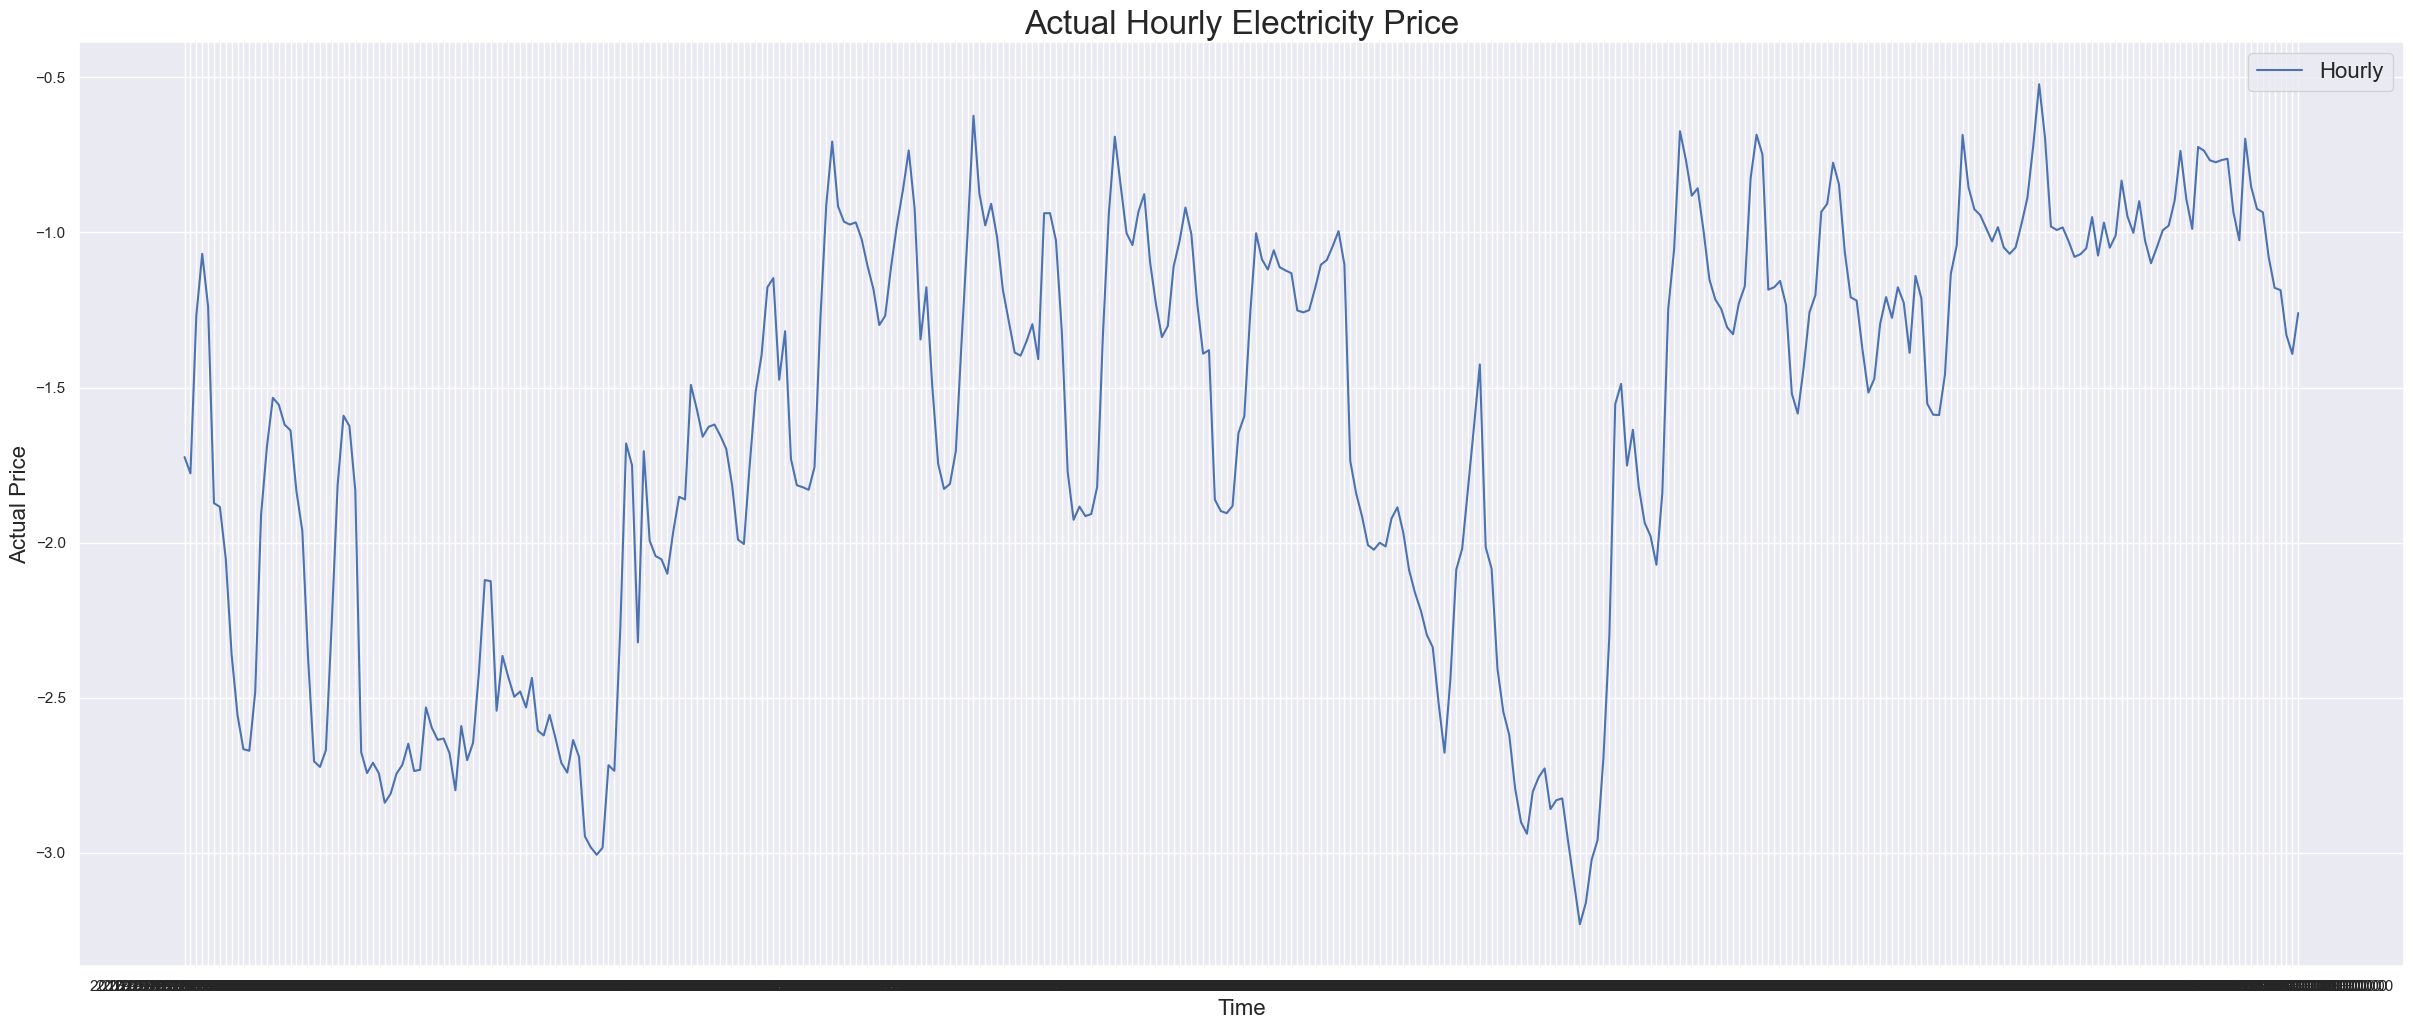

In [11]:
ax = plot_series(merged_data, 'price actual', label='Hourly', ylabel='Actual Price',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price')
plt.show()

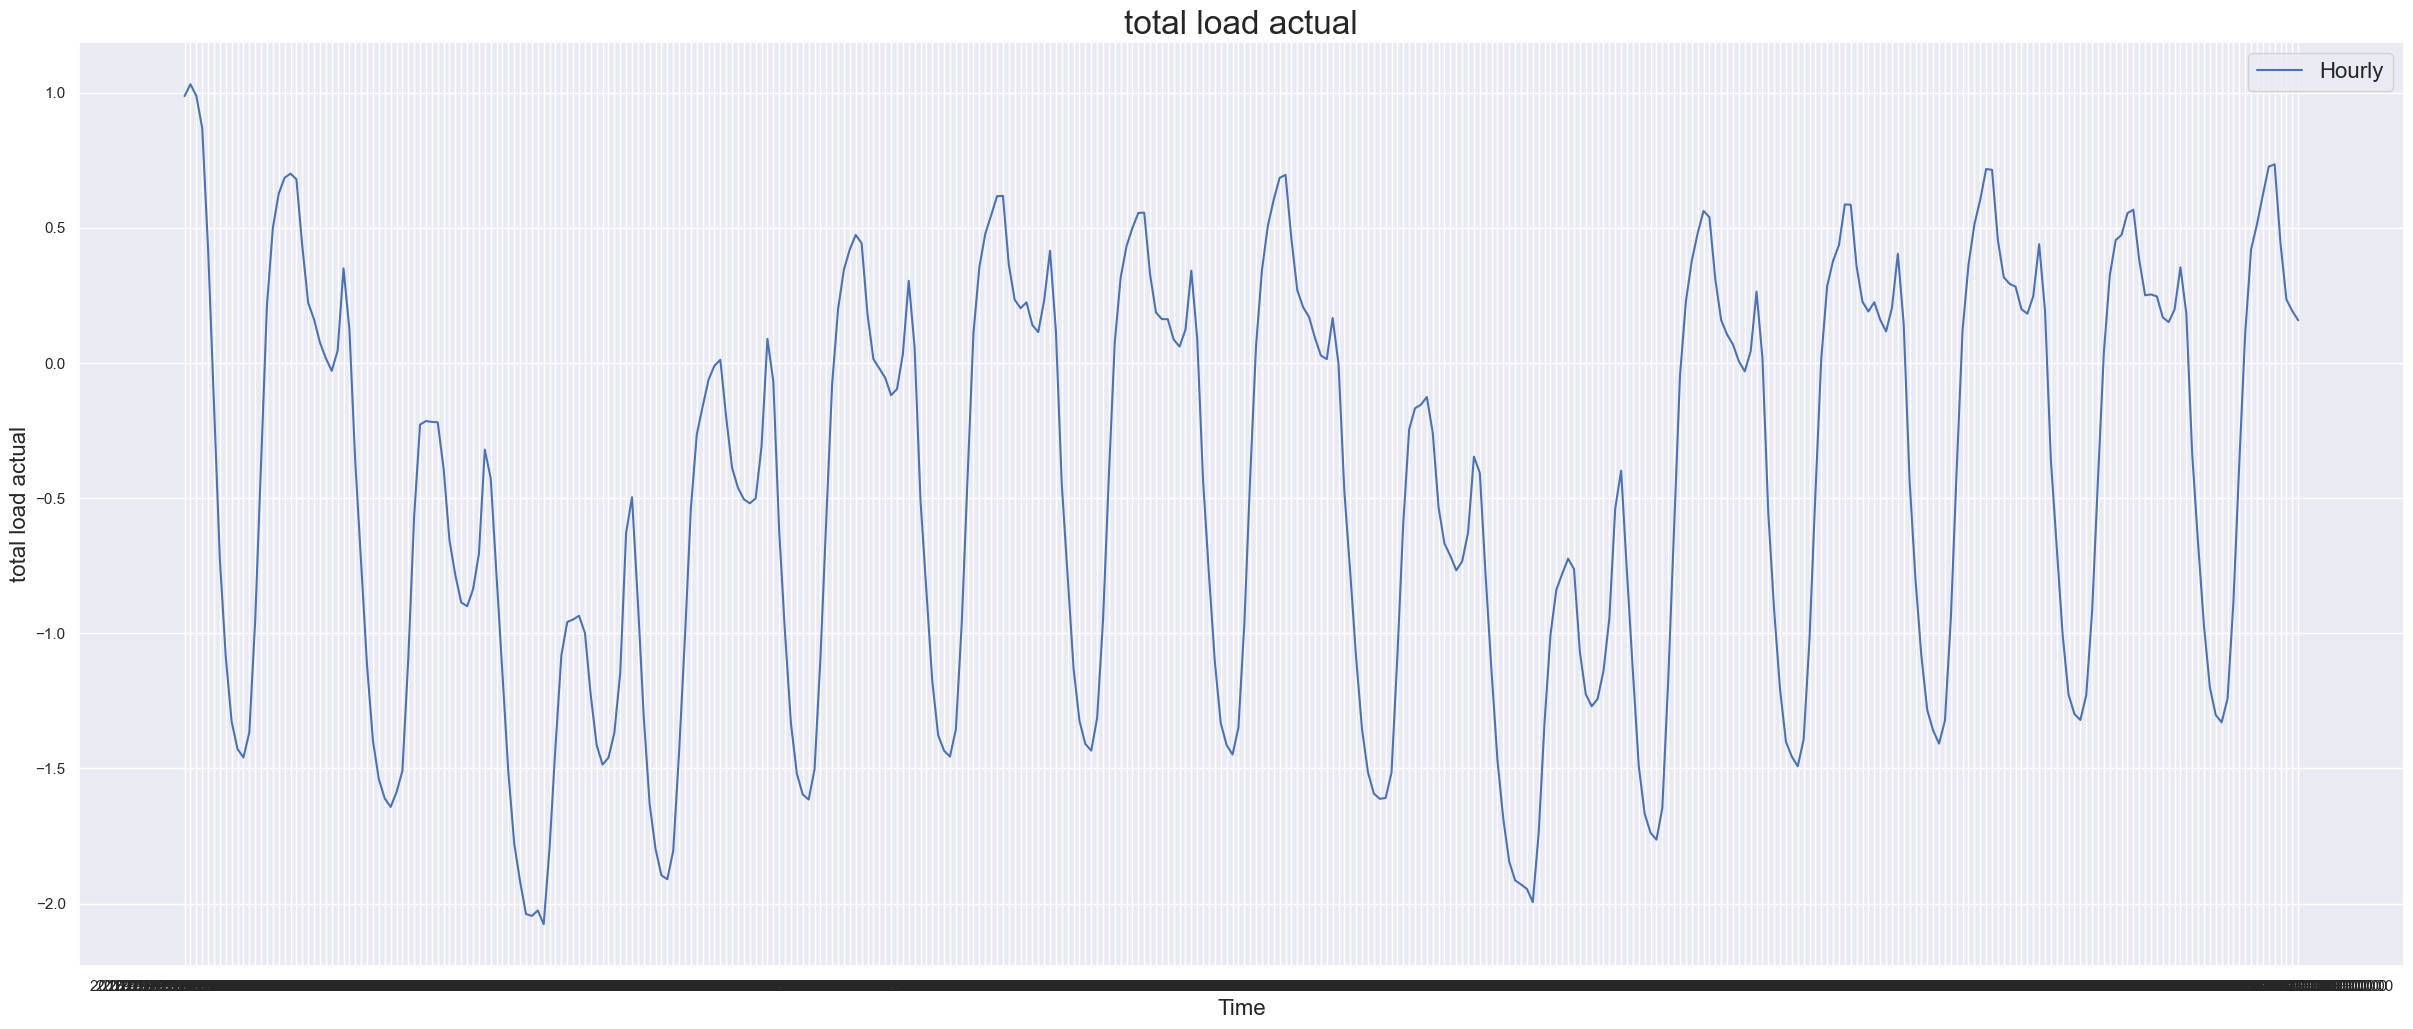

In [12]:
ax = plot_series(merged_data, 'total load actual', label='Hourly', ylabel='total load actual',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='total load actual')
plt.show()

---
---

In [13]:
# Check if data is ready for training
#
# columns are scaled (most standard distribution, some to [0, 1] range)
# removed redundant columns
# done time encoding
# one_hot encoding - weather_main
merged_data.dtypes

total load actual            float64
price actual                 float64
total_generation             float64
temp                         float64
temp_min                     float64
temp_max                     float64
pressure                     float64
humidity                     float64
wind_speed                   float64
weather_main_clear              bool
weather_main_clouds             bool
weather_main_drizzle            bool
weather_main_fog                bool
weather_main_haze               bool
weather_main_mist               bool
weather_main_rain               bool
weather_main_snow               bool
weather_main_thunderstorm       bool
hour_sin                     float64
hour_cos                     float64
day_of_week_sin              float64
day_of_week_cos              float64
day_of_month_sin             float64
day_of_month_cos             float64
month_sin                    float64
month_cos                    float64
day_of_year_sin              float64
d

---
---

In [9]:
def divide_data(data_all, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(data_all) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(data_all[indices])
        labels.append(target[i + target_size])
        

    return np.array(data), np.array(labels)

In [10]:
train_end_idx = int(36220 * 0.6)
val_end_idx = int(31200 * 0.8)
test_end_idx = 36220

In [17]:
# from sklearn.model_selection import TimeSeriesSplit

# tss = TimeSeriesSplit(n_splits = 3)

In [11]:
# preprare data for time series split
merged_data.sort_index(inplace=True)
X = merged_data[merged_data.columns.drop('total load actual')].values
y = merged_data['total load actual'].values
y = y.reshape(-1, 1)

In [19]:
# for train_index, test_index in tss.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [20]:
# # visualy check that test data is younger than train data
# def price2num(x):
#     if type(x) == str: 
#         x = x.strip('$').replace(',', '')
#     return float(x)
# #function to convert price from string to floats
# y_train = y_train.apply(price2num)
# y_train.groupby('time').mean().plot()
# y_test = y_test.apply(price2num)
# y_test.groupby('time').mean().plot()

In [12]:
# How many previous steps should the model keep as historical context
window_length = 10

In [13]:
X_train, y_train = divide_data(X, y,
                                    0, train_end_idx, window_length, 
                                    0, step=1)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [14]:
X_val, y_val = divide_data(X, y,
                                 train_end_idx, val_end_idx, window_length, 
                                 0, step=1)
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [15]:
X_test, y_test = divide_data(X, y,
                                   val_end_idx, test_end_idx, window_length, 
                                   0, step=1)
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

---
---

Create new folder for storing the trained models

In [16]:
# Save all trained models and their histories to adequate folders
# use datetime as identifier for folders
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
train_session_folder = f"train_session__{now}"
models_folder_name = f"{train_session_folder}/models"
histories_folder_name = f"{train_session_folder}/histories"

os.makedirs(train_session_folder, exist_ok=True)
os.makedirs(models_folder_name, exist_ok=True)
os.makedirs(histories_folder_name, exist_ok=True)
print(f'Current train session folder: {train_session_folder}')
print(f'Model save destination folder: {models_folder_name}')
print(f'History save destination folder: {histories_folder_name}')

In [17]:
# Save model to .h5 format and pickle the training history object
def save_model_and_training_history(model, model_name, history):
    # Save the weights
    model.save(f'{models_folder_name}/chckp__{model_name}.h5')
    print(f"Saved model as {models_folder_name}/chckp__{model_name}.h5")
    # save history 
    with open(f'{histories_folder_name}/histr__{model_name}.pkl', 'wb') as file_h:
        pickle.dump(history, file_h)
    print(f"Saved training history as {histories_folder_name}/histr__{model_name}.pkl")

In [18]:
def read_model(path_to_model, verbose=False):
    # Recreate the exact same model, including its weights and the optimizer
    new_model = tf.keras.models.load_model(f'{path_to_model}')

    # if verbose response
    if verbose is True:
        # show the model architecture
        new_model.summary()
    return new_model

In [19]:
def read_history(path_to_history):
    with open(f'{path_to_history}', 'rb') as file_h:
        pickle.load(file_h)

In [30]:
# TODO: train lstm models
# run on kaggle - kaggle compatible approach
# expected max train time (per model) < ~20 min
# 1. Compile model
# 2. Train for 50 epoch with early_stopping=10 epoch
# 3. Save model to .h5 format
# 4. Evaluate model - check val_loss value for overfitting and etc.
# 5. Change a single hiperparameter (egz. add a single lstm layer)
# 6. Back to point 1., if model improved add another lstm layer, if not create a new model from last improved one and change a different hiperparameter

In [31]:
# use eraly stopping method
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

min_training_eval_epochs = 50

---
---

## Create and train models

In [32]:
# Create the first LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_1 = Sequential()
model_LSTM_1.add(LSTM(32, input_shape = X_train.shape[-2:]))
model_LSTM_1.add(Flatten())
model_LSTM_1.add(Dropout(0.1))
model_LSTM_1.add(Dense(1))
model_LSTM_1.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [33]:
# Train the model
history_1 = model_LSTM_1.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50


679/679 [==============================] - 10s 9ms/step - loss: 0.6587 - root_mean_squared_error: 0.8116 - accuracy: 0.0000e+00 - val_loss: 0.4597 - val_root_mean_squared_error: 0.6780 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 5s 7ms/step - loss: 0.6101 - root_mean_squared_error: 0.7811 - accuracy: 0.0000e+00 - val_loss: 0.4507 - val_root_mean_squared_error: 0.6713 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 5s 8ms/step - loss: 0.6013 - root_mean_squared_error: 0.7754 - accuracy: 0.0000e+00 - val_loss: 0.4428 - val_root_mean_squared_error: 0.6654 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 6s 8ms/step - loss: 0.5945 - root_mean_squared_error: 0.7710 - accuracy: 0.0000e+00 - val_loss: 0.4453 - val_root_mean_squared_error: 0.6673 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 4s 6ms/step - loss: 0.5906 - root_mean_squared_error: 0

In [34]:
save_model_and_training_history(
    model_LSTM_1,
    f'{model_LSTM_1=}'.split('=')[0],
    history_1
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_1.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_1.pkl


History statistics: 
history.history['loss']=[0.6587182879447937, 0.6100620627403259, 0.6012641787528992, 0.5944817662239075, 0.5905696749687195, 0.5854480266571045, 0.5819862484931946, 0.5796176195144653, 0.577089786529541, 0.5746912956237793, 0.573637843132019, 0.571755051612854, 0.5702213048934937, 0.568604588508606, 0.5678961873054504, 0.5667586922645569, 0.5661086440086365, 0.5654252171516418, 0.5638490319252014, 0.5632287859916687, 0.5628337264060974, 0.5624737739562988, 0.5618189573287964, 0.5613040328025818, 0.5609863996505737, 0.5599165558815002, 0.5600078701972961, 0.5592160224914551, 0.5583857893943787, 0.5587855577468872, 0.5583247542381287, 0.5580828189849854, 0.557605504989624, 0.5574844479560852, 0.5567665696144104, 0.5569441914558411, 0.5567486882209778, 0.5559194684028625]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

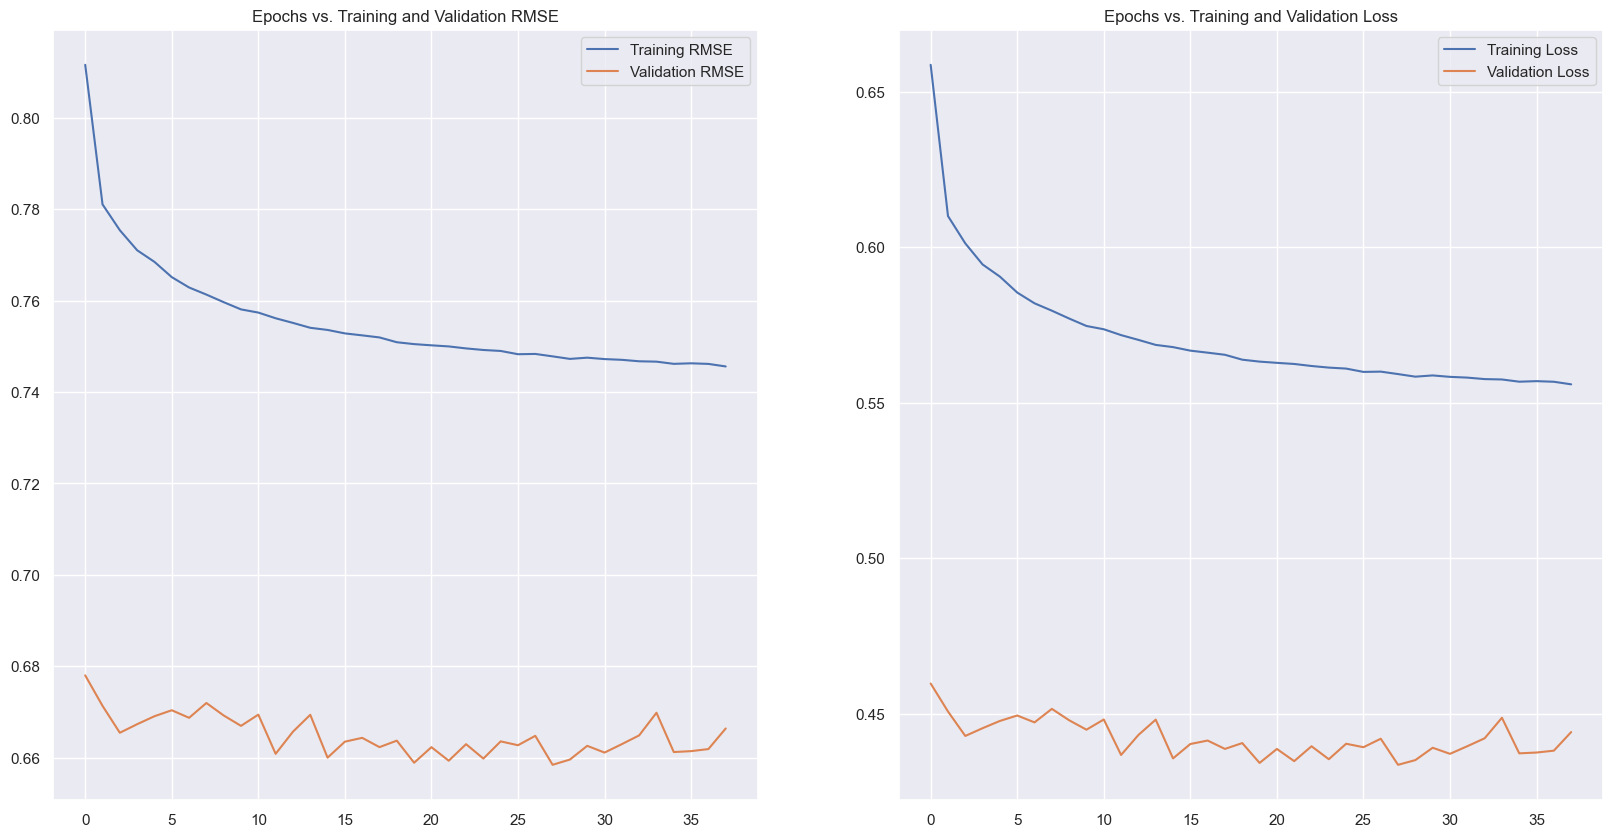

In [35]:
plot_results(history_1)

In [36]:
# Test reading trained model
new_read_model_LSTM_1 = read_model(f"{models_folder_name}/chckp__{f'{model_LSTM_1=}'.split('=')[0]}.h5", verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                7680      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7713 (30.13 KB)
Trainable params: 7713 (30.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Test reading model training history
new_read_history_1 = read_history(f"{histories_folder_name}/histr__{f'{model_LSTM_1=}'.split('=')[0]}.pkl")

---
### (2) Create new LSTM model based on previous performance
---

In [38]:
# Changes to model_LSTM_1
# Add new LSTM(32) layer 
# Add new Dense(8) layer

In [41]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_2 = Sequential()
model_LSTM_2.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_2.add(LSTM(32))
model_LSTM_2.add(Flatten())
model_LSTM_2.add(Dense(8, activation='relu'))
model_LSTM_2.add(Dropout(0.1))
model_LSTM_2.add(Dense(1))
model_LSTM_2.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [42]:
# Train the model
history_2 = model_LSTM_2.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 12s 12ms/step - loss: 0.3158 - root_mean_squared_error: 0.5620 - accuracy: 0.0000e+00 - val_loss: 0.1938 - val_root_mean_squared_error: 0.4403 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 6s 10ms/step - loss: 0.1784 - root_mean_squared_error: 0.4223 - accuracy: 0.0000e+00 - val_loss: 0.1554 - val_root_mean_squared_error: 0.3942 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 8s 12ms/step - loss: 0.1507 - root_mean_squared_error: 0.3882 - accuracy: 0.0000e+00 - val_loss: 0.1624 - val_root_mean_squared_error: 0.4030 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 11s 16ms/step - loss: 0.1331 - root_mean_squared_error: 0.3648 - accuracy: 0.0000e+00 - val_loss: 0.1476 - val_root_mean_squared_error: 0.3842 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 9s 13ms/step - loss: 0.1255 - root_mean_squared_erro

In [43]:
save_model_and_training_history(
    model_LSTM_2,
    f'{model_LSTM_2=}'.split('=')[0],
    history_2
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_2.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_2.pkl


History statistics: 
history.history['loss']=[0.315828800201416, 0.17835788428783417, 0.1507045328617096, 0.13309603929519653, 0.12548914551734924, 0.11629525572061539, 0.10881076008081436, 0.1031404435634613, 0.09626706689596176, 0.09245174378156662, 0.0898062065243721, 0.08628716319799423, 0.08210064470767975, 0.08180562406778336, 0.07937166839838028, 0.07681583613157272, 0.07264848798513412, 0.0720304623246193]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.19384188950061798, 0.15536557137966156, 0.1623949259519577, 0.14759859442710876, 0.14597226679325104, 0.17034024000167847, 0.13795000314712524, 0.12648706138134003, 0.14722654223442078, 0.1609385907649994, 0.12680108845233917, 0.13142789900302887, 0.13641555607318878, 0.1317320615053177, 0.13967271149158478, 0.14488808810710907, 0.13713130354881287, 0.13190151751041412]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0

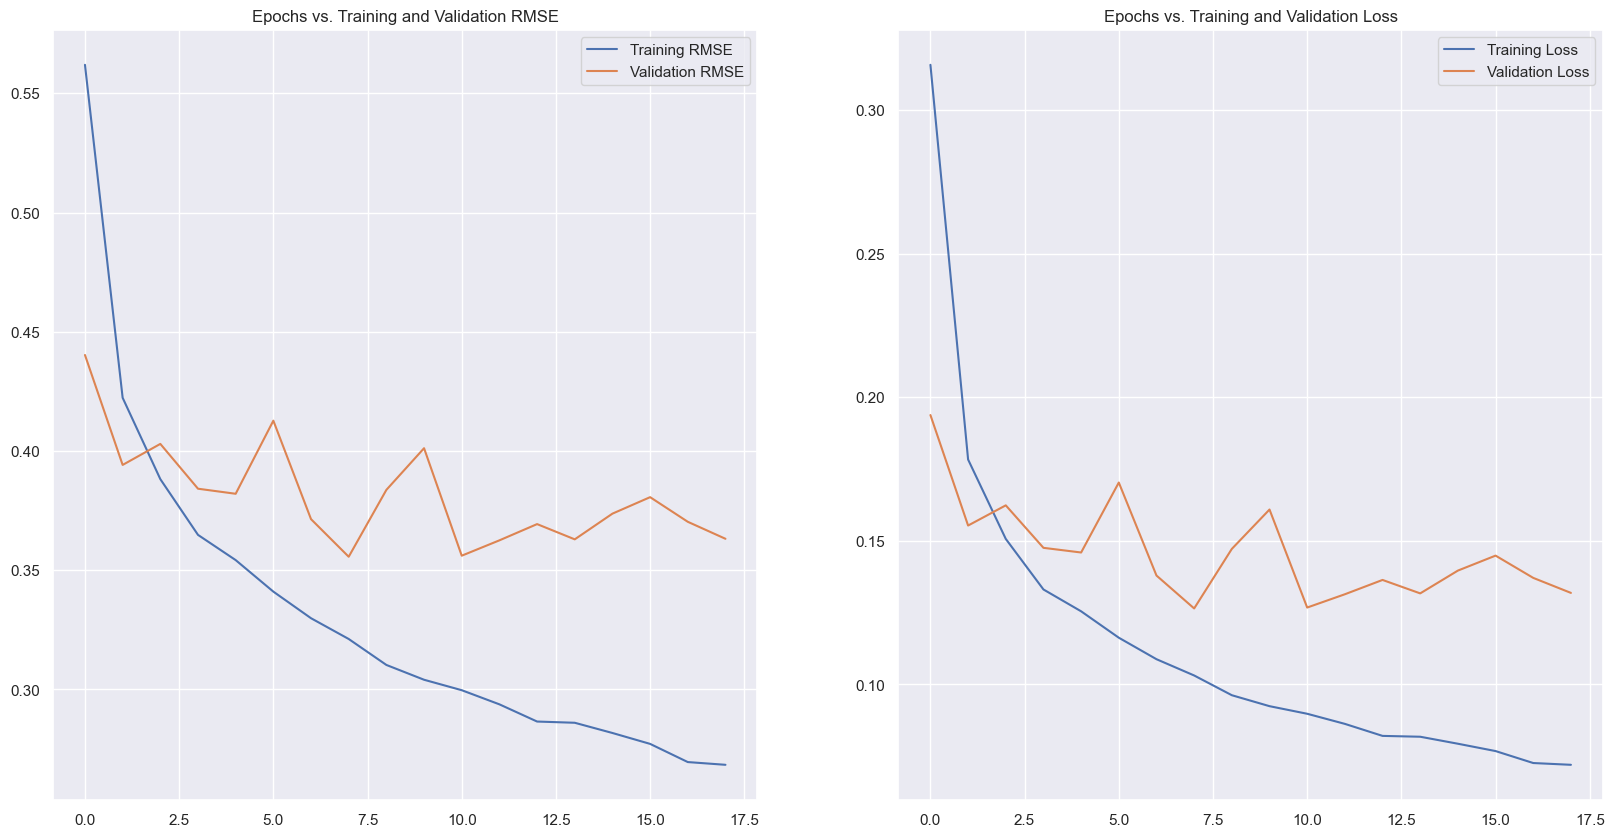

In [44]:
plot_results(history_2)

---
### (3) Create new LSTM model based on previous performance
---

In [46]:
# Changes to model_LSTM_2
# Add new LSTM(32) layer 
# Add new Dense(8) layer

In [48]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_3 = Sequential()
model_LSTM_3.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_3.add(LSTM(32, return_sequences=True))
model_LSTM_3.add(LSTM(32))
model_LSTM_3.add(Flatten())
model_LSTM_3.add(Dense(16, activation='relu'))
model_LSTM_3.add(Dropout(0.1))
model_LSTM_3.add(Dense(8, activation='relu'))
model_LSTM_3.add(Dropout(0.1))
model_LSTM_3.add(Dense(1))
model_LSTM_3.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [49]:
# Train the model
history_3 = model_LSTM_3.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 19s 17ms/step - loss: 0.3702 - root_mean_squared_error: 0.6085 - accuracy: 0.0000e+00 - val_loss: 0.2022 - val_root_mean_squared_error: 0.4497 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 12s 18ms/step - loss: 0.2110 - root_mean_squared_error: 0.4593 - accuracy: 0.0000e+00 - val_loss: 0.1663 - val_root_mean_squared_error: 0.4078 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 12s 18ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182 - accuracy: 0.0000e+00 - val_loss: 0.1240 - val_root_mean_squared_error: 0.3521 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 14s 20ms/step - loss: 0.1550 - root_mean_squared_error: 0.3938 - accuracy: 0.0000e+00 - val_loss: 0.1549 - val_root_mean_squared_error: 0.3935 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 13s 19ms/step - loss: 0.1422 - root_mean_squared_e

In [50]:
save_model_and_training_history(
    model_LSTM_3,
    f'{model_LSTM_3=}'.split('=')[0],
    history_3
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_3.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_3.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.3702230155467987, 0.21099621057510376, 0.17491276562213898, 0.1550476998090744, 0.14222677052021027, 0.13246963918209076, 0.12281590700149536, 0.11801739037036896, 0.11393614113330841, 0.10756458342075348, 0.1041993498802185, 0.09782420098781586, 0.09411952644586563]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.2022119164466858, 0.16626989841461182, 0.12396782636642456, 0.15485118329524994, 0.12625905871391296, 0.1366838812828064, 0.14625805616378784, 0.14579355716705322, 0.14122629165649414, 0.14596760272979736, 0.14809247851371765, 0.1303880661725998, 0.13883523643016815]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


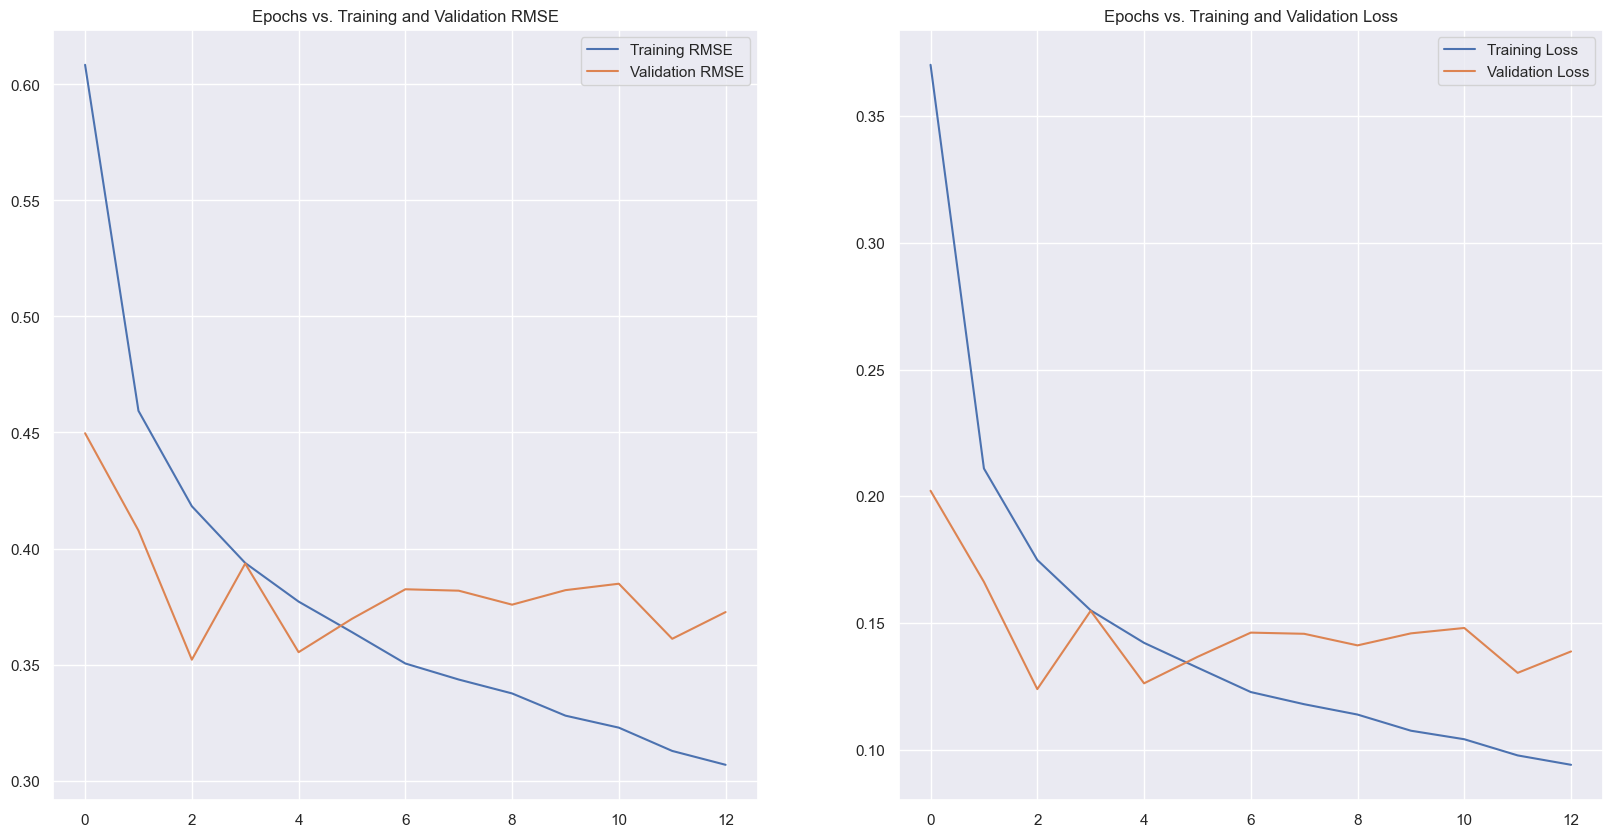

In [51]:
plot_results(history_3)

---
### (4) Create new LSTM model based on previous performance
---

In [52]:
# Changes to model_LSTM_3
# Add new LSTM(32) layer 
# Add new Dense(8) layer

In [53]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_4 = Sequential()
model_LSTM_4.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_4.add(LSTM(32, return_sequences=True))
model_LSTM_4.add(LSTM(32, return_sequences=True))
model_LSTM_4.add(LSTM(32))
model_LSTM_4.add(Flatten())
model_LSTM_4.add(Dense(32, activation='relu'))
model_LSTM_4.add(Dropout(0.1))
model_LSTM_4.add(Dense(16, activation='relu'))
model_LSTM_4.add(Dropout(0.1))
model_LSTM_4.add(Dense(8, activation='relu'))
model_LSTM_4.add(Dropout(0.1))
model_LSTM_4.add(Dense(1))
model_LSTM_4.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [54]:
# Train the model
history_4 = model_LSTM_4.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 26s 24ms/step - loss: 0.4050 - root_mean_squared_error: 0.6364 - accuracy: 0.0000e+00 - val_loss: 0.2026 - val_root_mean_squared_error: 0.4501 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 15s 23ms/step - loss: 0.2268 - root_mean_squared_error: 0.4762 - accuracy: 0.0000e+00 - val_loss: 0.2404 - val_root_mean_squared_error: 0.4903 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1874 - root_mean_squared_error: 0.4329 - accuracy: 0.0000e+00 - val_loss: 0.1637 - val_root_mean_squared_error: 0.4045 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 17s 25ms/step - loss: 0.1615 - root_mean_squared_error: 0.4018 - accuracy: 0.0000e+00 - val_loss: 0.1300 - val_root_mean_squared_error: 0.3605 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 19s 28ms/step - loss: 0.1475 - root_mean_squared_e

In [57]:
save_model_and_training_history(
    model_LSTM_4,
    f'{model_LSTM_4=}'.split('=')[0],
    history_4
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_4.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_4.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.40502944588661194, 0.22680410742759705, 0.18736983835697174, 0.16147887706756592, 0.1475217491388321, 0.13518381118774414, 0.1268203854560852, 0.11947490274906158, 0.11289823800325394, 0.10865072906017303, 0.1041305735707283, 0.09855422377586365, 0.09399307519197464, 0.09221978485584259]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.20263050496578217, 0.24036580324172974, 0.16365821659564972, 0.12997660040855408, 0.15071819722652435, 0.22173291444778442, 0.13385224342346191, 0.13324980437755585, 0.1453435868024826, 0.18261688947677612, 0.14007094502449036, 0.15139861404895782, 0.1665295660495758, 0.14077222347259521]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


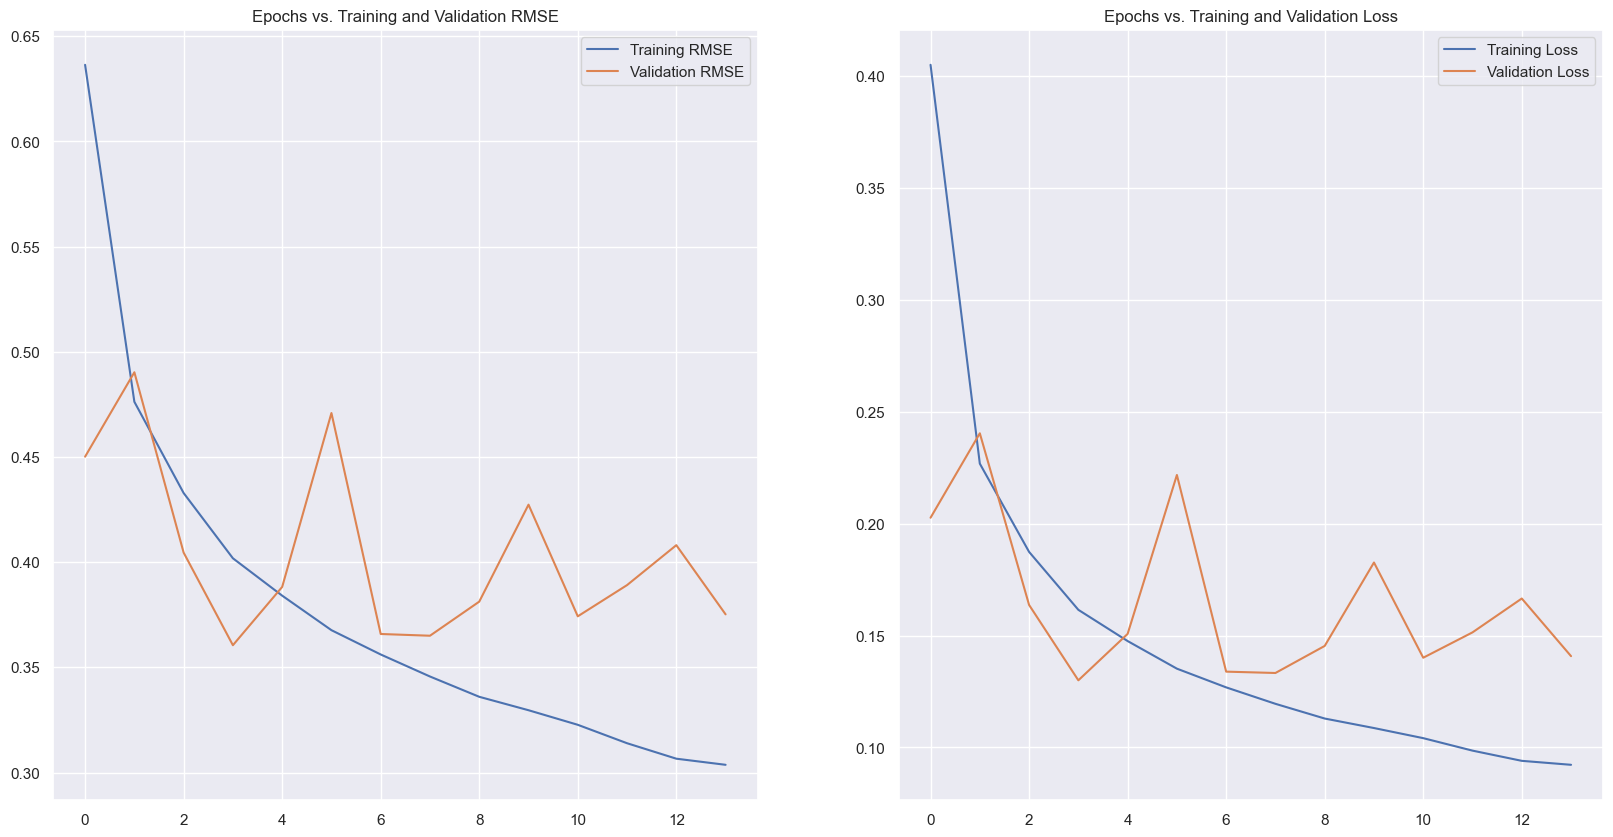

In [58]:
plot_results(history_4)

---
### (5) Create new LSTM model based on previous performance
---

In [59]:
# Changes to model_LSTM_4
# Increased dropout rate 0.1 -> 0.3

In [60]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_5 = Sequential()
model_LSTM_5.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_5.add(LSTM(32, return_sequences=True))
model_LSTM_5.add(LSTM(32, return_sequences=True))
model_LSTM_5.add(LSTM(32))
model_LSTM_5.add(Flatten())
model_LSTM_5.add(Dense(32, activation='relu'))
model_LSTM_5.add(Dropout(0.3))
model_LSTM_5.add(Dense(16, activation='relu'))
model_LSTM_5.add(Dropout(0.1))
model_LSTM_5.add(Dense(8, activation='relu'))
model_LSTM_5.add(Dropout(0.1))
model_LSTM_5.add(Dense(1))
model_LSTM_5.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [61]:
# Train the model
history_5 = model_LSTM_5.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 29s 29ms/step - loss: 0.4060 - root_mean_squared_error: 0.6372 - accuracy: 0.0000e+00 - val_loss: 0.2061 - val_root_mean_squared_error: 0.4540 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 17s 25ms/step - loss: 0.2380 - root_mean_squared_error: 0.4878 - accuracy: 0.0000e+00 - val_loss: 0.1902 - val_root_mean_squared_error: 0.4361 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393 - accuracy: 0.0000e+00 - val_loss: 0.2723 - val_root_mean_squared_error: 0.5218 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1672 - root_mean_squared_error: 0.4089 - accuracy: 0.0000e+00 - val_loss: 0.1545 - val_root_mean_squared_error: 0.3931 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1536 - root_mean_squared_e

In [62]:
save_model_and_training_history(
    model_LSTM_5,
    f'{model_LSTM_5=}'.split('=')[0],
    history_5
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_5.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_5.pkl


History statistics: 
history.history['loss']=[0.4060257077217102, 0.23797576129436493, 0.1929972618818283, 0.16716362535953522, 0.15358607470989227, 0.143485426902771, 0.1325029730796814, 0.12826624512672424, 0.12182807922363281, 0.11606281250715256, 0.1095871552824974, 0.10626915842294693, 0.10149557143449783, 0.09654238820075989, 0.09349923580884933, 0.09019991755485535]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.20613060891628265, 0.1901533603668213, 0.27230075001716614, 0.15450164675712585, 0.18167315423488617, 0.151869535446167, 0.20044632256031036, 0.1791413575410843, 0.17716491222381592, 0.2024604231119156, 0.19084317982196808, 0.18945284187793732, 0.1571299433708191, 0.17961479723453522, 0.1971558779478073, 0.19227255880832672]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


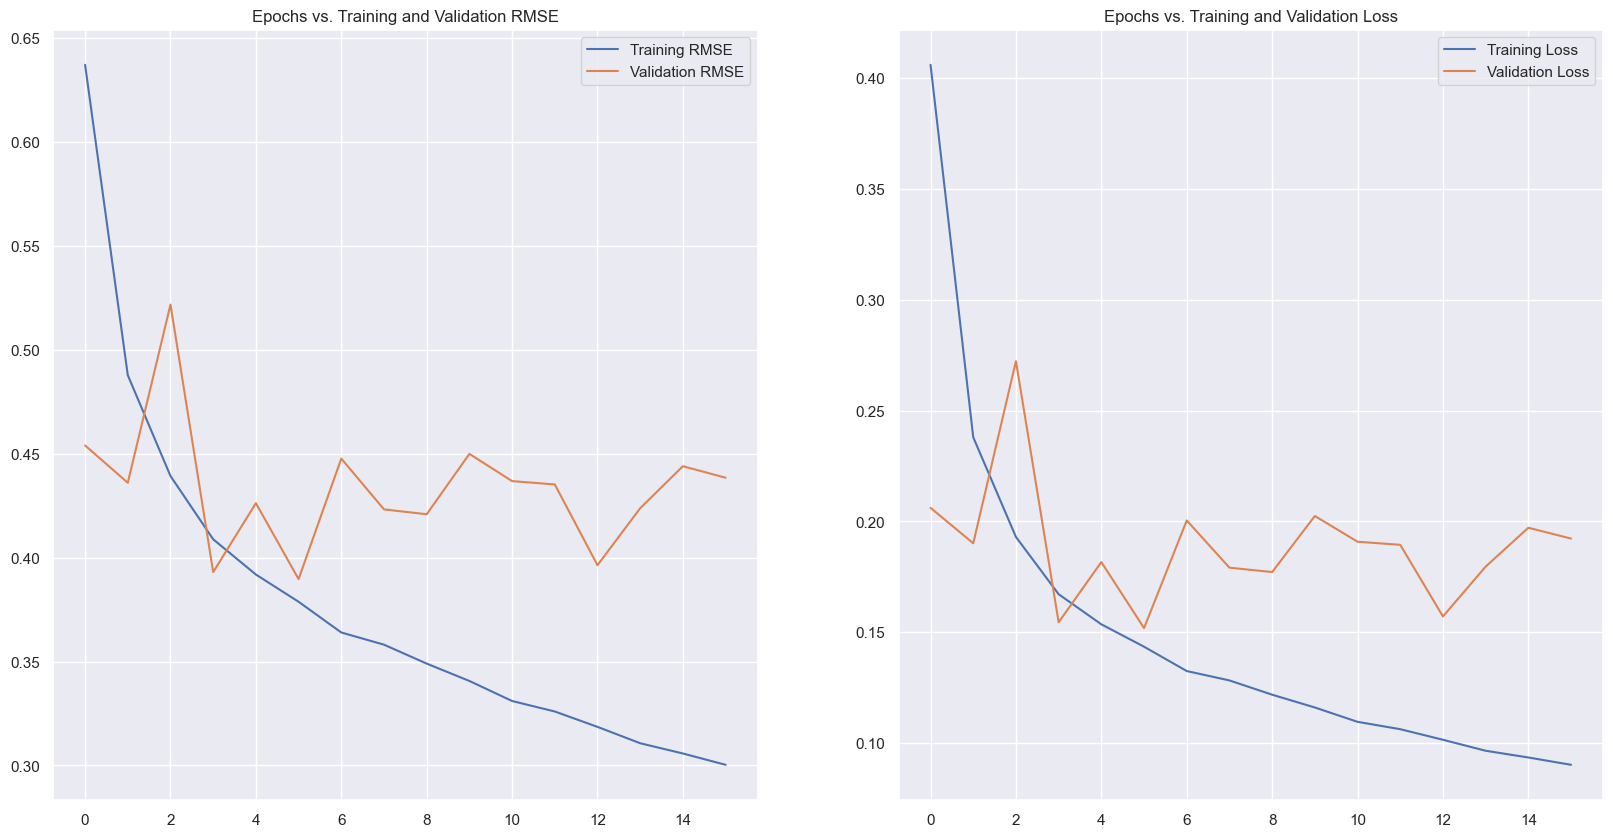

In [63]:
plot_results(history_5)

---
### (6) Create new LSTM model based on previous performance
---

In [65]:
# Changes to model_LSTM_5
# Remove LSTM(32) layer and Dense(32) layer
# Change LSTM(32) to LSTM(16) 

In [66]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_6 = Sequential()
model_LSTM_6.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_6.add(LSTM(16, return_sequences=True))
model_LSTM_6.add(LSTM(32))
model_LSTM_6.add(Flatten())
model_LSTM_6.add(Dense(16, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(Dense(8, activation='relu'))
model_LSTM_6.add(Dropout(0.1))
model_LSTM_6.add(Dense(1))
model_LSTM_6.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [67]:
# Train the model
history_6 = model_LSTM_6.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 20s 20ms/step - loss: 0.4095 - root_mean_squared_error: 0.6399 - accuracy: 0.0000e+00 - val_loss: 0.2676 - val_root_mean_squared_error: 0.5173 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 12s 17ms/step - loss: 0.2418 - root_mean_squared_error: 0.4918 - accuracy: 0.0000e+00 - val_loss: 0.2217 - val_root_mean_squared_error: 0.4708 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 14s 20ms/step - loss: 0.1972 - root_mean_squared_error: 0.4440 - accuracy: 0.0000e+00 - val_loss: 0.1667 - val_root_mean_squared_error: 0.4083 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 12s 18ms/step - loss: 0.1701 - root_mean_squared_error: 0.4124 - accuracy: 0.0000e+00 - val_loss: 0.1899 - val_root_mean_squared_error: 0.4358 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 12s 18ms/step - loss: 0.1598 - root_mean_squared_e

In [68]:
save_model_and_training_history(
    model_LSTM_6,
    f'{model_LSTM_6=}'.split('=')[0],
    history_6
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_6.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_6.pkl


History statistics: 
history.history['loss']=[0.4095347225666046, 0.24184764921665192, 0.1971784234046936, 0.1701120287179947, 0.15981796383857727, 0.14686016738414764, 0.13762745261192322, 0.13230982422828674, 0.12670548260211945, 0.12144358456134796, 0.11785805970430374, 0.11460018157958984, 0.11072146147489548, 0.10574270039796829, 0.10468938946723938, 0.10345476120710373, 0.10018657892942429, 0.09854617714881897, 0.09861800074577332, 0.09347089380025864, 0.09156361222267151, 0.09537099301815033, 0.09072811156511307, 0.08832545578479767, 0.08695489168167114, 0.0874105840921402, 0.08524346351623535, 0.081808902323246]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.26761361956596375, 0.2216847836971283, 0.1667308509349823, 0.18991465866565704, 0.16660477221012115, 0.17825137078762054, 0.15382754802703857, 0.20067575573921204, 0.174658

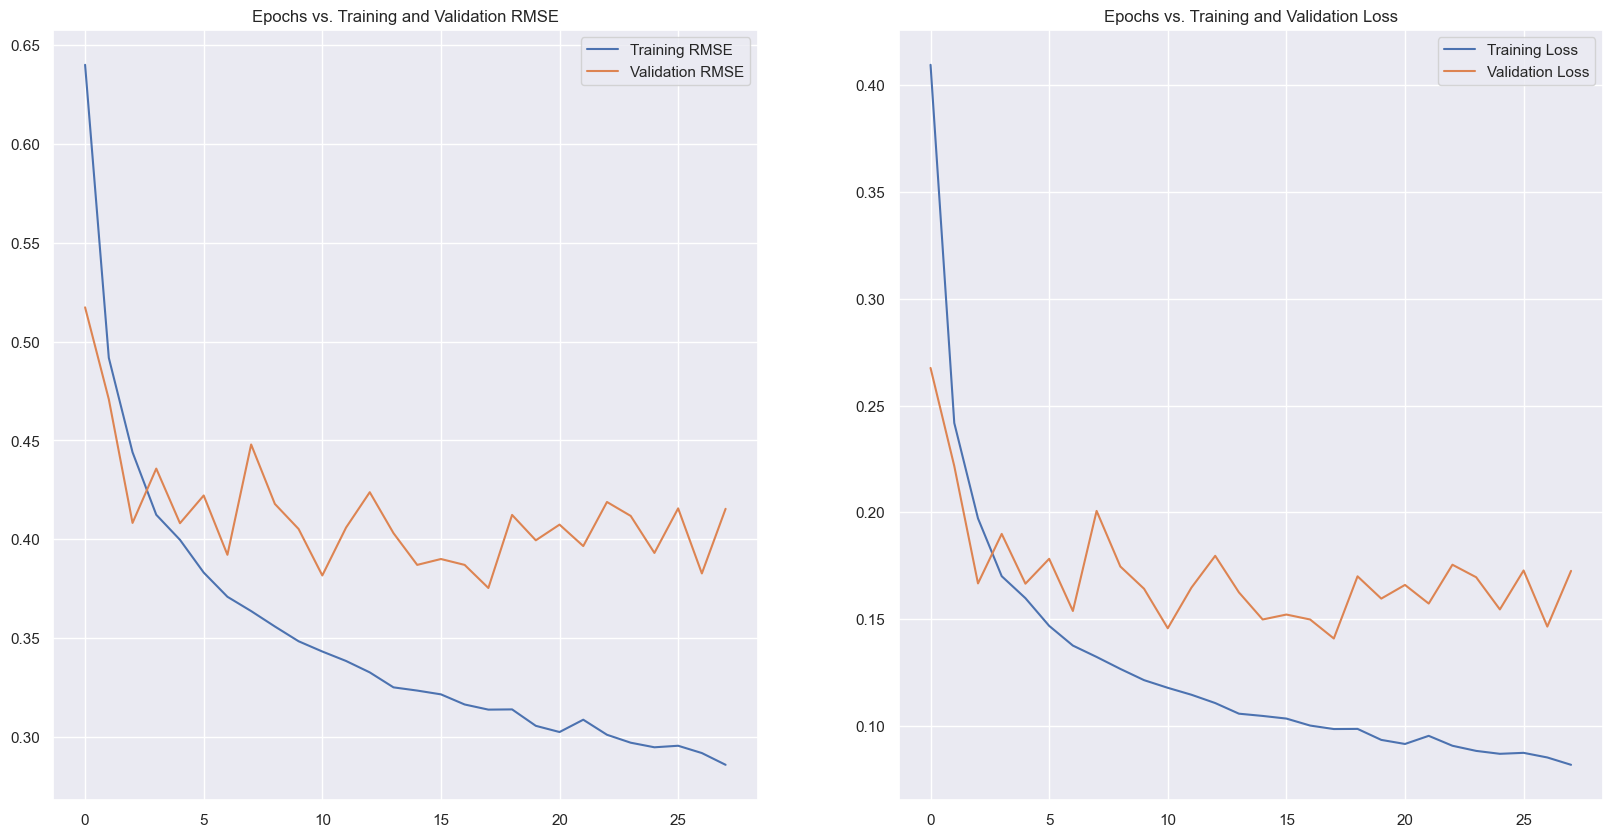

In [69]:
plot_results(history_6)

---
### (7) Create new LSTM model based on previous performance
---

In [71]:
# Changes to model_LSTM_6
# increase dropout 0.1 -> 0.2

In [72]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_7 = Sequential()
model_LSTM_7.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_7.add(LSTM(16, return_sequences=True))
model_LSTM_7.add(LSTM(32))
model_LSTM_7.add(Flatten())
model_LSTM_7.add(Dense(16, activation='relu'))
model_LSTM_7.add(Dropout(0.3))
model_LSTM_7.add(Dense(8, activation='relu'))
model_LSTM_7.add(Dropout(0.2))
model_LSTM_7.add(Dense(1))
model_LSTM_7.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [73]:
# Train the model
history_7 = model_LSTM_7.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 23s 23ms/step - loss: 0.4343 - root_mean_squared_error: 0.6590 - accuracy: 0.0000e+00 - val_loss: 0.2124 - val_root_mean_squared_error: 0.4609 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 16s 24ms/step - loss: 0.2694 - root_mean_squared_error: 0.5190 - accuracy: 0.0000e+00 - val_loss: 0.2124 - val_root_mean_squared_error: 0.4608 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 23s 35ms/step - loss: 0.2353 - root_mean_squared_error: 0.4850 - accuracy: 0.0000e+00 - val_loss: 0.2085 - val_root_mean_squared_error: 0.4566 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 34s 50ms/step - loss: 0.2079 - root_mean_squared_error: 0.4559 - accuracy: 0.0000e+00 - val_loss: 0.1649 - val_root_mean_squared_error: 0.4061 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 30s 44ms/step - loss: 0.1970 - root_mean_squared_e

In [74]:
save_model_and_training_history(
    model_LSTM_7,
    f'{model_LSTM_7=}'.split('=')[0],
    history_7
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_7.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_7.pkl


History statistics: 
history.history['loss']=[0.43425044417381287, 0.2693790793418884, 0.23526491224765778, 0.2078648954629898, 0.1970335990190506, 0.1874750554561615, 0.17943190038204193, 0.1716267615556717, 0.16872259974479675, 0.16115087270736694, 0.15439912676811218, 0.15389832854270935, 0.14907309412956238, 0.1474994719028473, 0.1422073096036911, 0.1386568695306778, 0.1392224282026291, 0.13276547193527222, 0.1302836388349533, 0.12963737547397614, 0.13154689967632294, 0.1271570324897766, 0.12858012318611145, 0.1255250871181488]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.21243725717067719, 0.21236833930015564, 0.20845557749271393, 0.1649036556482315, 0.1641615629196167, 0.13174951076507568, 0.14975328743457794, 0.13390576839447021, 0.15767061710357666, 0.14574414491653442, 0.12877099215984344, 0.14019463956356049, 0.15443263947963715, 0.12524825334

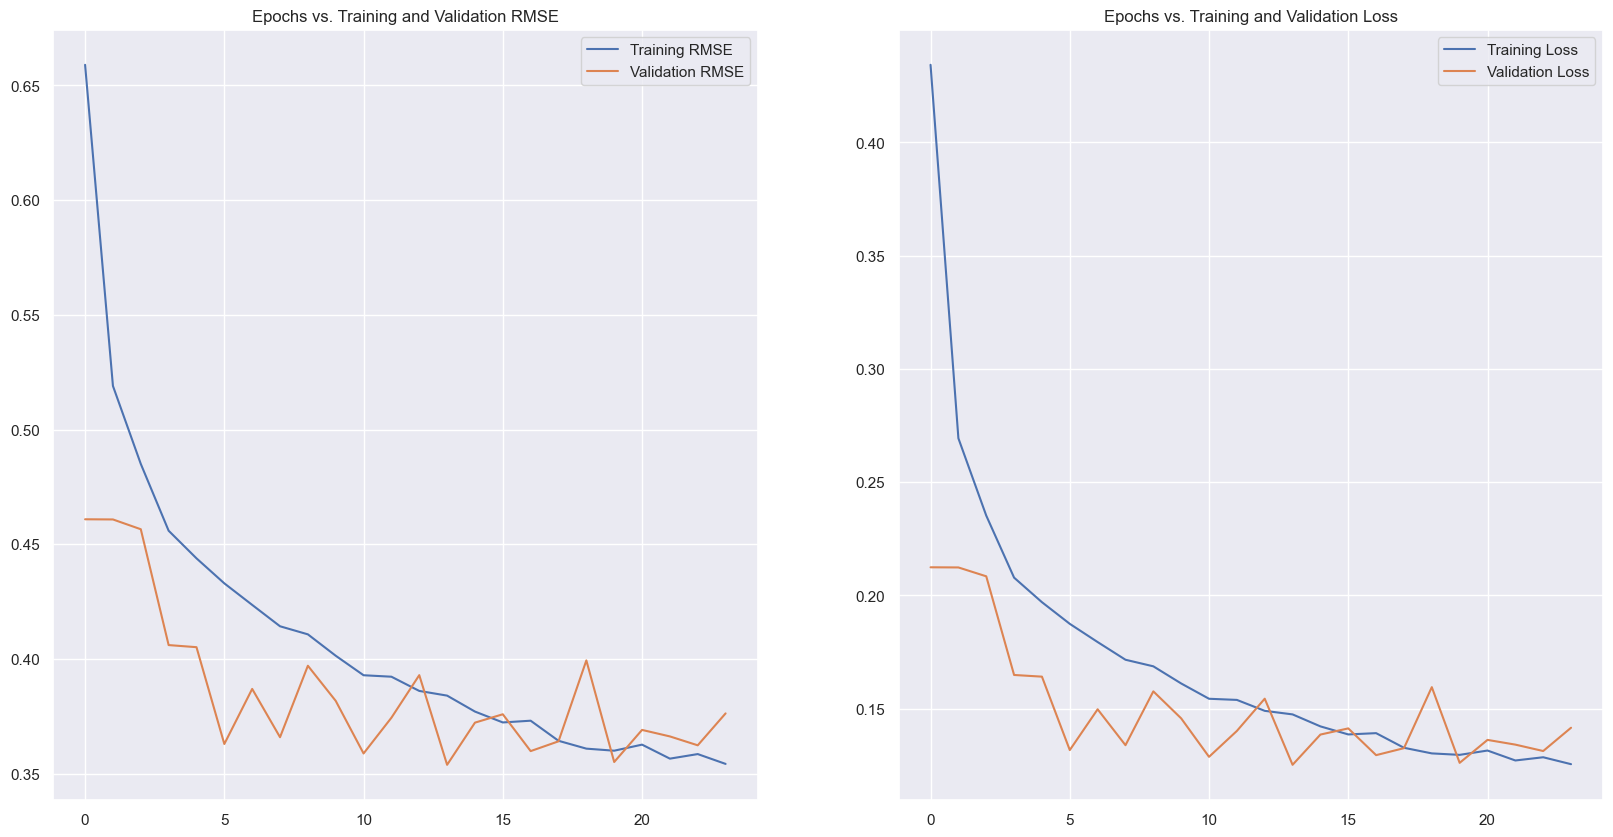

In [75]:
plot_results(history_7)

---
### (8) Create new LSTM model based on previous performance
---

In [77]:
# Changes to model_LSTM_7
# remove Dense(8) and Dropout(0.3) layers

In [78]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_8 = Sequential()
model_LSTM_8.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_8.add(LSTM(16, return_sequences=True))
model_LSTM_8.add(LSTM(32))
model_LSTM_8.add(Flatten())
model_LSTM_8.add(Dense(16, activation='relu'))
model_LSTM_8.add(Dropout(0.2))
model_LSTM_8.add(Dense(1))
model_LSTM_8.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [79]:
# Train the model
history_8 = model_LSTM_8.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 26s 27ms/step - loss: 0.3422 - root_mean_squared_error: 0.5849 - accuracy: 0.0000e+00 - val_loss: 0.1908 - val_root_mean_squared_error: 0.4368 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1948 - root_mean_squared_error: 0.4414 - accuracy: 0.0000e+00 - val_loss: 0.1396 - val_root_mean_squared_error: 0.3736 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1589 - root_mean_squared_error: 0.3986 - accuracy: 0.0000e+00 - val_loss: 0.1312 - val_root_mean_squared_error: 0.3622 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1429 - root_mean_squared_error: 0.3781 - accuracy: 0.0000e+00 - val_loss: 0.1647 - val_root_mean_squared_error: 0.4058 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 16s 23ms/step - loss: 0.1321 - root_mean_squared_e

In [80]:
save_model_and_training_history(
    model_LSTM_8,
    f'{model_LSTM_8=}'.split('=')[0],
    history_8
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_8.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_8.pkl


History statistics: 
history.history['loss']=[0.34215521812438965, 0.19483116269111633, 0.15885932743549347, 0.14294134080410004, 0.13206446170806885, 0.12353983521461487, 0.11630168557167053, 0.1110190749168396, 0.10488151758909225, 0.10028305649757385, 0.09518072009086609, 0.09102893620729446, 0.08853670209646225, 0.08747770637273788, 0.08296848833560944, 0.08149510622024536, 0.07926669716835022, 0.07801187038421631, 0.07489366829395294, 0.07605069875717163, 0.07302545756101608, 0.07143052667379379, 0.06971108913421631, 0.06918665766716003, 0.06821765750646591]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.19081580638885498, 0.1395590901374817, 0.13122376799583435, 0.16467106342315674, 0.12160465121269226, 0.12207084149122238, 0.11952482908964157, 0.13948561251163483, 0.11386751383543015, 0.13077816367149353, 0.15052159130573273, 0.112038403749465

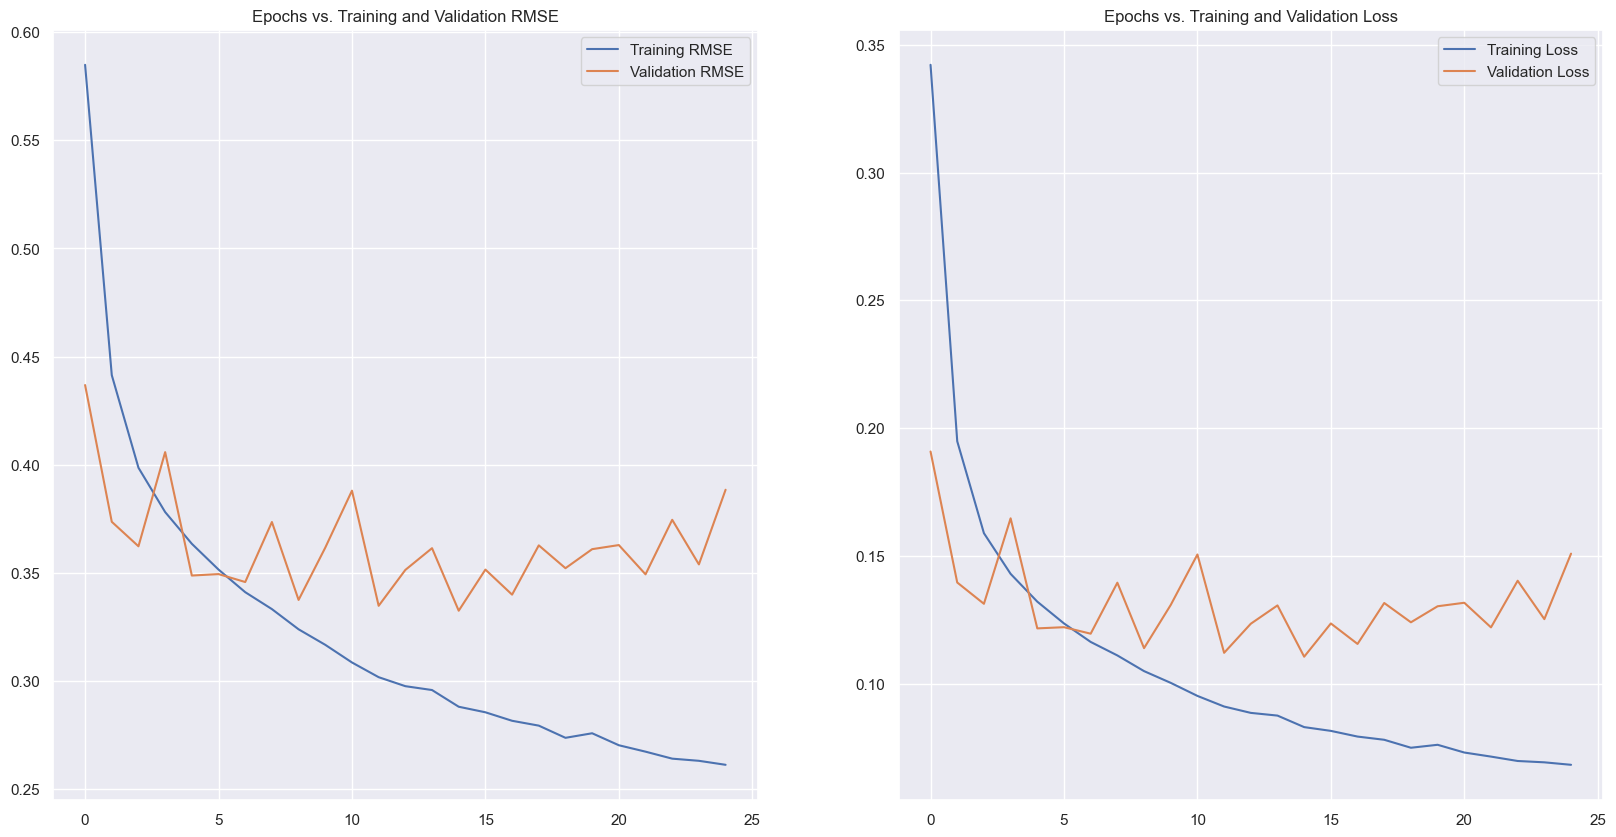

In [81]:
plot_results(history_8)

---
### (9) Create new LSTM model based on previous performance
---

In [83]:
# Changes to model_LSTM_7
# increase dropout 0.2 -> 0.3

In [84]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_9 = Sequential()
model_LSTM_9.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_9.add(LSTM(16, return_sequences=True))
model_LSTM_9.add(LSTM(32))
model_LSTM_9.add(Flatten())
model_LSTM_9.add(Dense(16, activation='relu'))
model_LSTM_9.add(Dropout(0.3))
model_LSTM_9.add(Dense(8, activation='relu'))
model_LSTM_9.add(Dropout(0.3))
model_LSTM_9.add(Dense(1))
model_LSTM_9.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [85]:
# Train the model
history_9 = model_LSTM_9.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 21s 21ms/step - loss: 0.4631 - root_mean_squared_error: 0.6805 - accuracy: 0.0000e+00 - val_loss: 0.2734 - val_root_mean_squared_error: 0.5229 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 21s 31ms/step - loss: 0.3134 - root_mean_squared_error: 0.5598 - accuracy: 0.0000e+00 - val_loss: 0.1879 - val_root_mean_squared_error: 0.4334 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 24s 36ms/step - loss: 0.2743 - root_mean_squared_error: 0.5237 - accuracy: 0.0000e+00 - val_loss: 0.1977 - val_root_mean_squared_error: 0.4446 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 18s 26ms/step - loss: 0.2500 - root_mean_squared_error: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.1332 - val_root_mean_squared_error: 0.3649 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 16s 23ms/step - loss: 0.2344 - root_mean_squared_e

In [86]:
save_model_and_training_history(
    model_LSTM_9,
    f'{model_LSTM_9=}'.split('=')[0],
    history_9
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_9.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_9.pkl


History statistics: 
history.history['loss']=[0.46309342980384827, 0.3133915066719055, 0.27428796887397766, 0.24995744228363037, 0.2343573272228241, 0.219976007938385, 0.21875888109207153, 0.2112012356519699, 0.20925980806350708, 0.2054343819618225, 0.2027616798877716, 0.2008194774389267, 0.19294200837612152, 0.19271576404571533, 0.1853042095899582, 0.18967539072036743, 0.18398834764957428, 0.1851138472557068, 0.18026261031627655, 0.18133218586444855, 0.17667163908481598, 0.17540636658668518, 0.1709553748369217]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.27340805530548096, 0.18786753714084625, 0.1977023184299469, 0.13316433131694794, 0.1489165872335434, 0.1560441553592682, 0.17674031853675842, 0.12798167765140533, 0.1523885279893875, 0.14228026568889618, 0.15595000982284546, 0.12242456525564194, 0.11858399957418442, 0.14380282163619995, 0.12440605461597443

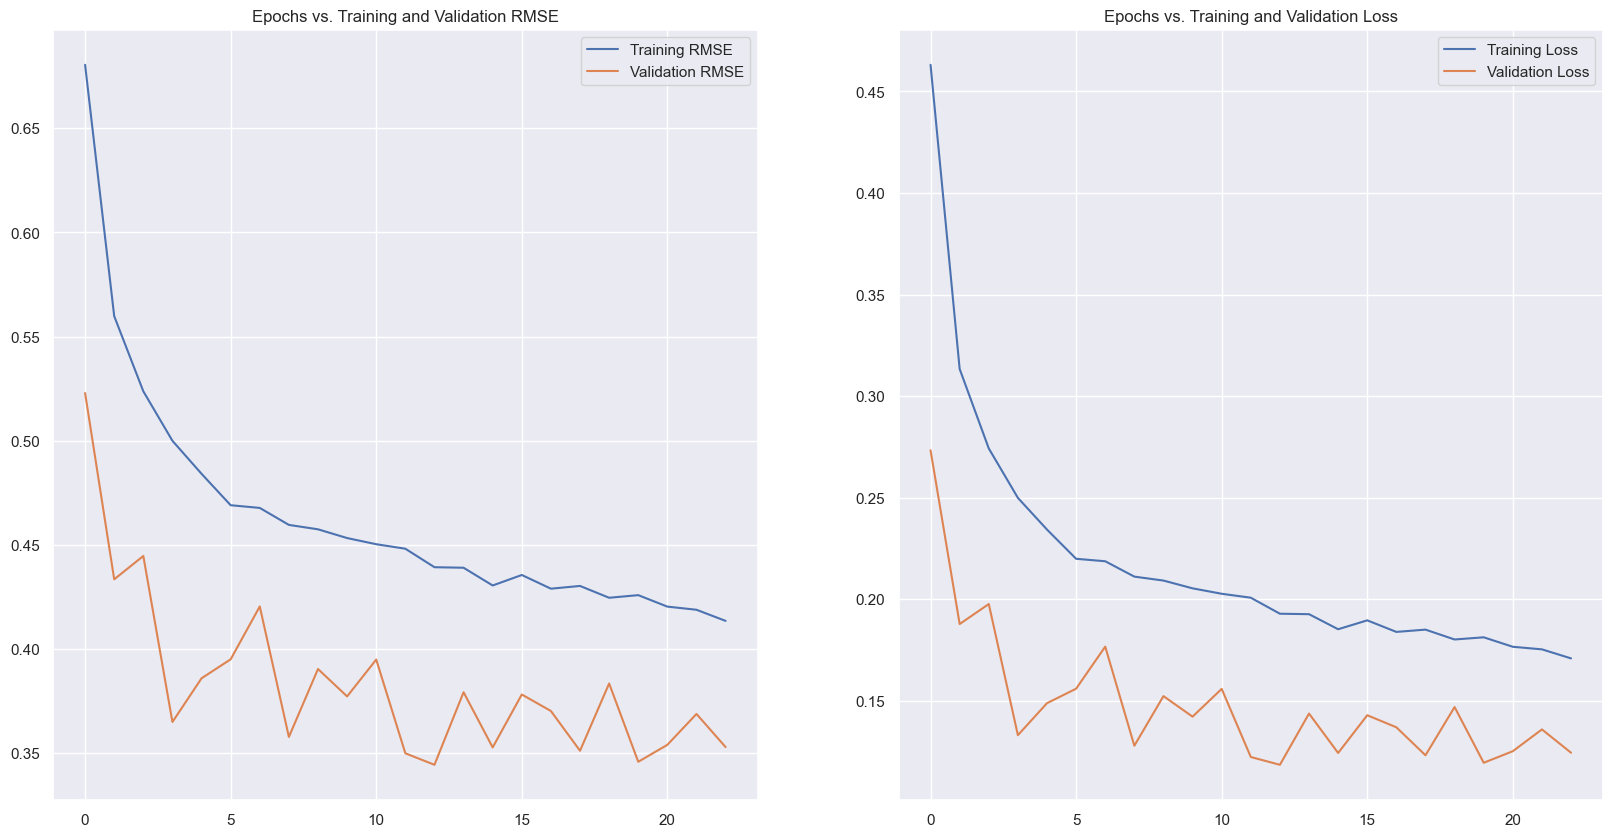

In [87]:
plot_results(history_9)

---
### (10) Create new LSTM model based on previous performance
---

In [88]:
# Changes to model_LSTM_6
# Change LSTM(32) to LSTM(16)

In [89]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_10 = Sequential()
model_LSTM_10.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_10.add(LSTM(16, return_sequences=True))
model_LSTM_10.add(LSTM(16))
model_LSTM_10.add(Flatten())
model_LSTM_10.add(Dense(16, activation='relu'))
model_LSTM_10.add(Dropout(0.3))
model_LSTM_10.add(Dense(8, activation='relu'))
model_LSTM_10.add(Dropout(0.2))
model_LSTM_10.add(Dense(1))
model_LSTM_10.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [90]:
# Train the model
history_10 = model_LSTM_10.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 24s 24ms/step - loss: 0.4514 - root_mean_squared_error: 0.6718 - accuracy: 0.0000e+00 - val_loss: 0.2136 - val_root_mean_squared_error: 0.4622 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 16s 23ms/step - loss: 0.2781 - root_mean_squared_error: 0.5273 - accuracy: 0.0000e+00 - val_loss: 0.1725 - val_root_mean_squared_error: 0.4153 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 15s 22ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869 - accuracy: 0.0000e+00 - val_loss: 0.2188 - val_root_mean_squared_error: 0.4677 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 16s 24ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621 - accuracy: 0.0000e+00 - val_loss: 0.1821 - val_root_mean_squared_error: 0.4267 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 16s 23ms/step - loss: 0.2028 - root_mean_squared_e

In [91]:
save_model_and_training_history(
    model_LSTM_10,
    f'{model_LSTM_10=}'.split('=')[0],
    history_10
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_10.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_10.pkl


History statistics: 
history.history['loss']=[0.45136788487434387, 0.27806204557418823, 0.2370830923318863, 0.21351930499076843, 0.20283259451389313, 0.18719184398651123, 0.18194951117038727, 0.1728283315896988, 0.1684546023607254, 0.1620551496744156, 0.15442492067813873, 0.15526188910007477, 0.1519816815853119, 0.1474251002073288, 0.14254863560199738, 0.14312972128391266, 0.13925544917583466, 0.1363244205713272]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.21360629796981812, 0.17249679565429688, 0.21878136694431305, 0.18205681443214417, 0.15915098786354065, 0.13670219480991364, 0.181974858045578, 0.11497775465250015, 0.14642441272735596, 0.12884777784347534, 0.14881056547164917, 0.1290436089038849, 0.14668644964694977, 0.16764231026172638, 0.15028536319732666, 0.14987708628177643, 0.16462065279483795, 0.1301080584526062]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0

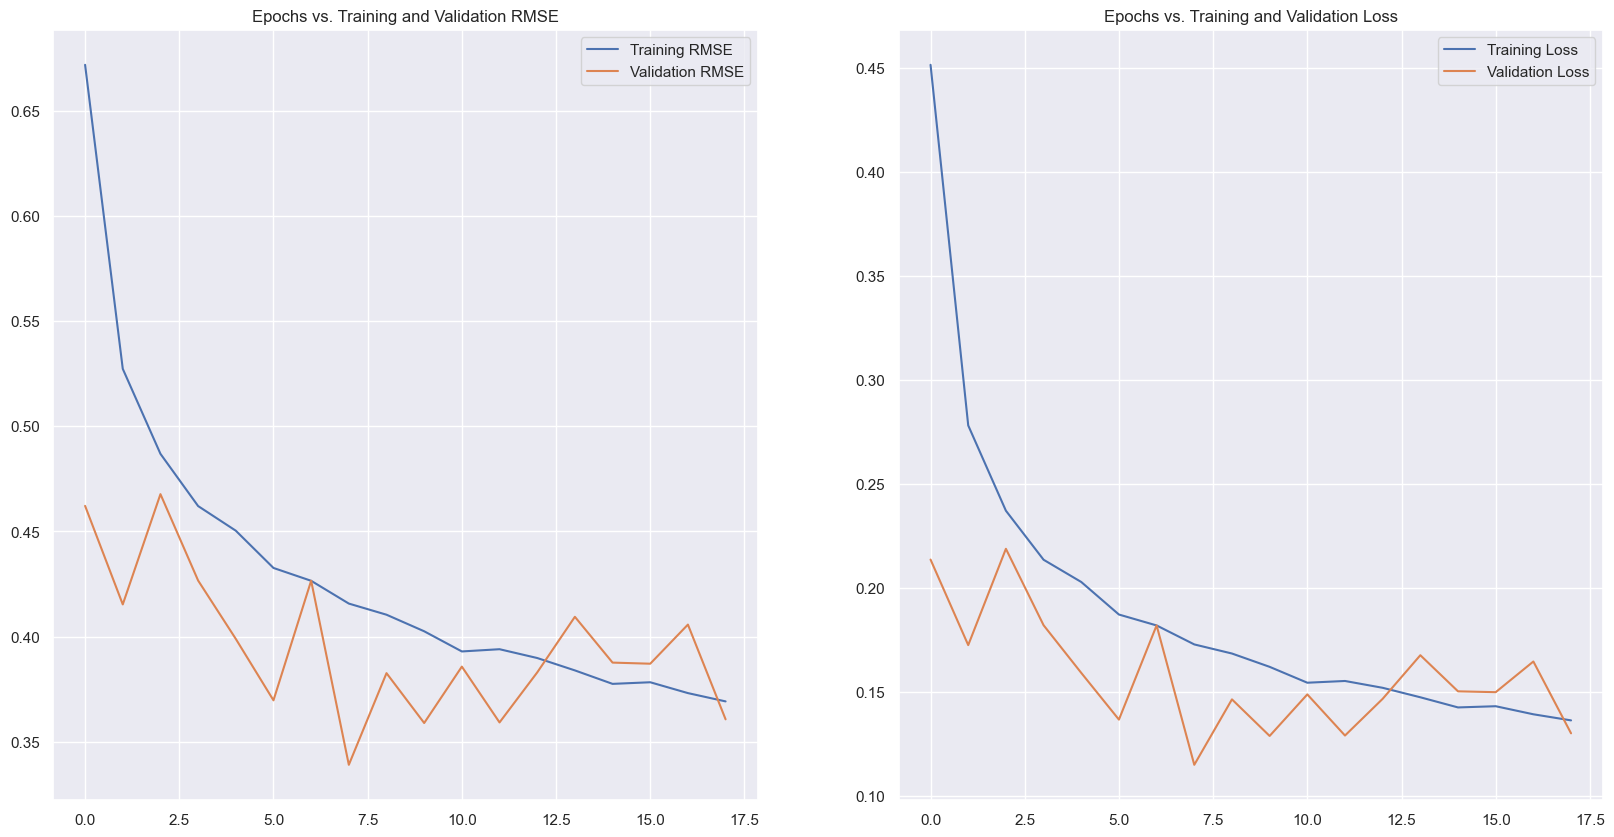

In [92]:
plot_results(history_10)

---
### (11) Create new LSTM model based on previous performance
---

In [94]:
# Changes to model_LSTM_10
# increase cells in second LSTM layer from 16 to 32

In [95]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_11 = Sequential()
model_LSTM_11.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_11.add(LSTM(32, return_sequences=True))
model_LSTM_11.add(LSTM(16))
model_LSTM_11.add(Flatten())
model_LSTM_11.add(Dense(16, activation='relu'))
model_LSTM_11.add(Dropout(0.3))
model_LSTM_11.add(Dense(8, activation='relu'))
model_LSTM_11.add(Dropout(0.2))
model_LSTM_11.add(Dense(1))
model_LSTM_11.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [96]:
# Train the model
history_11 = model_LSTM_11.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 30s 30ms/step - loss: 0.4292 - root_mean_squared_error: 0.6551 - accuracy: 0.0000e+00 - val_loss: 0.2212 - val_root_mean_squared_error: 0.4703 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 17s 25ms/step - loss: 0.2598 - root_mean_squared_error: 0.5097 - accuracy: 0.0000e+00 - val_loss: 0.2021 - val_root_mean_squared_error: 0.4496 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 17s 26ms/step - loss: 0.2240 - root_mean_squared_error: 0.4732 - accuracy: 0.0000e+00 - val_loss: 0.1704 - val_root_mean_squared_error: 0.4128 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 17s 25ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521 - accuracy: 0.0000e+00 - val_loss: 0.2116 - val_root_mean_squared_error: 0.4600 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 17s 26ms/step - loss: 0.1895 - root_mean_squared_e

In [97]:
save_model_and_training_history(
    model_LSTM_11,
    f'{model_LSTM_11=}'.split('=')[0],
    history_11
)

C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model as train_session__20231127_000227/models/chckp__model_LSTM_11.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_11.pkl


History statistics: 
history.history['loss']=[0.429155170917511, 0.2597642242908478, 0.22395533323287964, 0.20437204837799072, 0.1895417422056198, 0.1811191886663437, 0.17831693589687347, 0.1697297990322113, 0.16228796541690826, 0.15685398876667023, 0.1520528495311737, 0.1456993967294693, 0.14310039579868317, 0.1377885639667511, 0.1367088258266449, 0.13287609815597534, 0.1328509896993637, 0.1270151287317276, 0.1268608421087265, 0.12482882291078568, 0.12291283160448074, 0.11928824335336685]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.22122476994991302, 0.2021329402923584, 0.17042869329452515, 0.2116100937128067, 0.1520969122648239, 0.18498465418815613, 0.1349755972623825, 0.13698796927928925, 0.13971097767353058, 0.15309754014015198, 0.15564456582069397, 0.1321134716272354, 0.15833958983421326, 0.15155042707920074, 0.1424320936203003, 0.1530013233423233, 0.142528

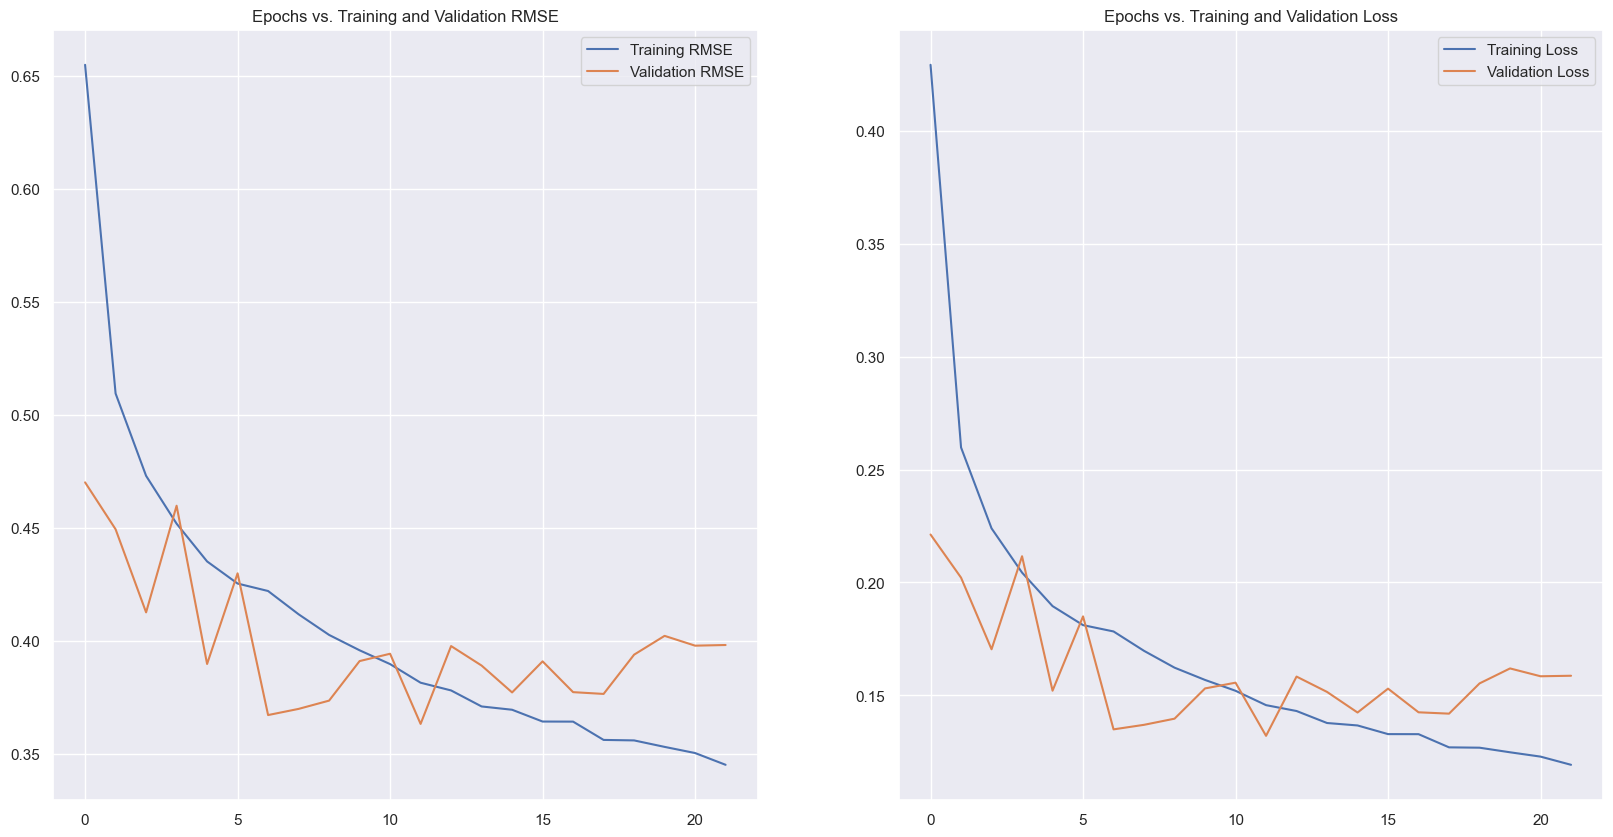

In [98]:
plot_results(history_11)

---
### (12) Create new LSTM model based on previous performance
---

In [99]:
# Changes to model_LSTM_11
# change activation function in Dense(16) layer from relu to tanh

In [100]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_12 = Sequential()
model_LSTM_12.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_12.add(LSTM(32, return_sequences=True))
model_LSTM_12.add(LSTM(16))
model_LSTM_12.add(Flatten())
model_LSTM_12.add(Dense(16, activation='tanh'))
model_LSTM_12.add(Dropout(0.3))
model_LSTM_12.add(Dense(8, activation='relu'))
model_LSTM_12.add(Dropout(0.2))
model_LSTM_12.add(Dense(1))
model_LSTM_12.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [101]:
# Train the model
history_12 = model_LSTM_12.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 26s 26ms/step - loss: 0.3774 - root_mean_squared_error: 0.6144 - accuracy: 0.0000e+00 - val_loss: 0.2095 - val_root_mean_squared_error: 0.4577 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 12s 17ms/step - loss: 0.2443 - root_mean_squared_error: 0.4942 - accuracy: 0.0000e+00 - val_loss: 0.1698 - val_root_mean_squared_error: 0.4121 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 12s 17ms/step - loss: 0.2115 - root_mean_squared_error: 0.4598 - accuracy: 0.0000e+00 - val_loss: 0.1335 - val_root_mean_squared_error: 0.3654 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 11s 16ms/step - loss: 0.1931 - root_mean_squared_error: 0.4394 - accuracy: 0.0000e+00 - val_loss: 0.1563 - val_root_mean_squared_error: 0.3953 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 10s 15ms/step - loss: 0.1792 - root_mean_squared_e

In [102]:
save_model_and_training_history(
    model_LSTM_12,
    f'{model_LSTM_12=}'.split('=')[0],
    history_12
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_12.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_12.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.3774396479129791, 0.2442667931318283, 0.2114580124616623, 0.19311612844467163, 0.17915140092372894, 0.17381387948989868, 0.1644924432039261, 0.1602863371372223, 0.1560196876525879, 0.15290820598602295, 0.14795354008674622, 0.14221477508544922, 0.1369747668504715, 0.13497361540794373, 0.1315677911043167, 0.13231149315834045]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.20949864387512207, 0.16984963417053223, 0.13350223004817963, 0.1562502235174179, 0.1584887057542801, 0.11248800903558731, 0.1230669915676117, 0.1419275403022766, 0.1541249006986618, 0.11513746529817581, 0.172798752784729, 0.13845913112163544, 0.12421718239784241, 0.12188351154327393, 0.1315591037273407, 0.13793867826461792]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


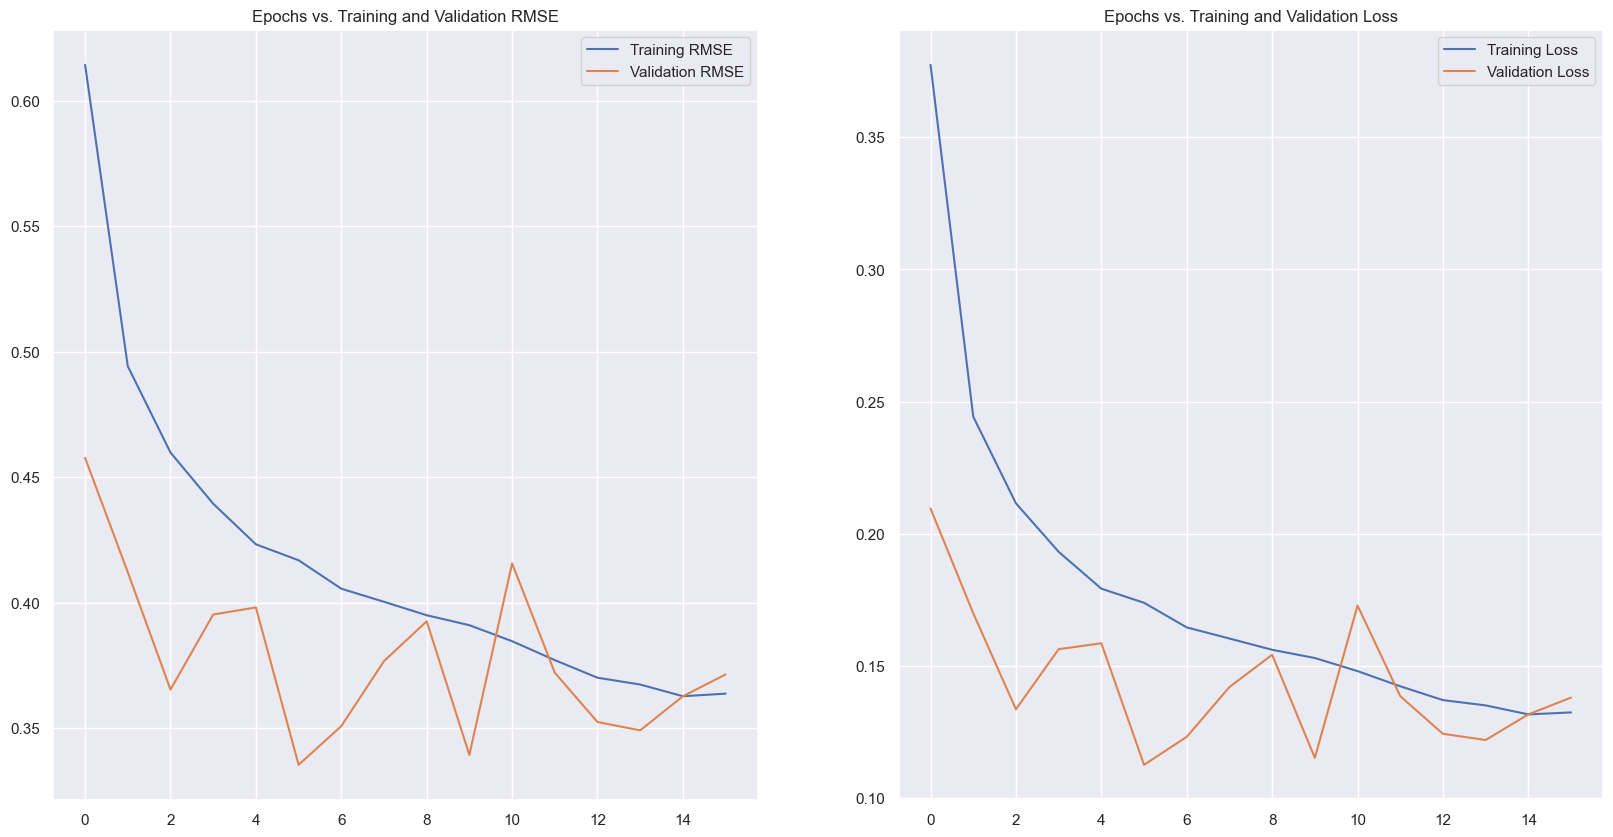

In [103]:
plot_results(history_12)

---
### (13) Create new LSTM model based on previous performance
---

In [104]:
# Changes to model_LSTM_12
# increase Dense(8) layer to Dense(16)

In [105]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_13 = Sequential()
model_LSTM_13.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_13.add(LSTM(32, return_sequences=True))
model_LSTM_13.add(LSTM(16))
model_LSTM_13.add(Flatten())
model_LSTM_13.add(Dense(16, activation='tanh'))
model_LSTM_13.add(Dropout(0.3))
model_LSTM_13.add(Dense(8, activation='relu'))
model_LSTM_13.add(Dropout(0.2))
model_LSTM_13.add(Dense(1))
model_LSTM_13.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [106]:
# Train the model
history_13 = model_LSTM_13.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 43s 48ms/step - loss: 0.3854 - root_mean_squared_error: 0.6208 - accuracy: 0.0000e+00 - val_loss: 0.2005 - val_root_mean_squared_error: 0.4478 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 19s 28ms/step - loss: 0.2432 - root_mean_squared_error: 0.4932 - accuracy: 0.0000e+00 - val_loss: 0.1430 - val_root_mean_squared_error: 0.3781 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 16s 23ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598 - accuracy: 0.0000e+00 - val_loss: 0.1677 - val_root_mean_squared_error: 0.4096 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 20s 29ms/step - loss: 0.1956 - root_mean_squared_error: 0.4422 - accuracy: 0.0000e+00 - val_loss: 0.1566 - val_root_mean_squared_error: 0.3957 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 17s 25ms/step - loss: 0.1823 - root_mean_squared_e

In [107]:
save_model_and_training_history(
    model_LSTM_13,
    f'{model_LSTM_13=}'.split('=')[0],
    history_13
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_13.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_13.pkl


History statistics: 
history.history['loss']=[0.3854304850101471, 0.2431991994380951, 0.21137672662734985, 0.19558387994766235, 0.18228033185005188, 0.17169642448425293, 0.1637871414422989, 0.160873681306839, 0.1542564332485199, 0.14686785638332367, 0.14647680521011353, 0.14111179113388062, 0.1375706046819687, 0.13186296820640564, 0.12893801927566528, 0.12898768484592438, 0.12760508060455322, 0.12453439086675644, 0.12277919054031372, 0.12044131755828857, 0.11787012219429016]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.20049740374088287, 0.14299194514751434, 0.16774886846542358, 0.15655584633350372, 0.11720754206180573, 0.15600524842739105, 0.13561777770519257, 0.13686072826385498, 0.1316285878419876, 0.13489004969596863, 0.11628741025924683, 0.13463585078716278, 0.15568755567073822, 0.1268165409564972, 0.15182770788669586, 0.15375304222106934, 0.12669843435287476, 0.

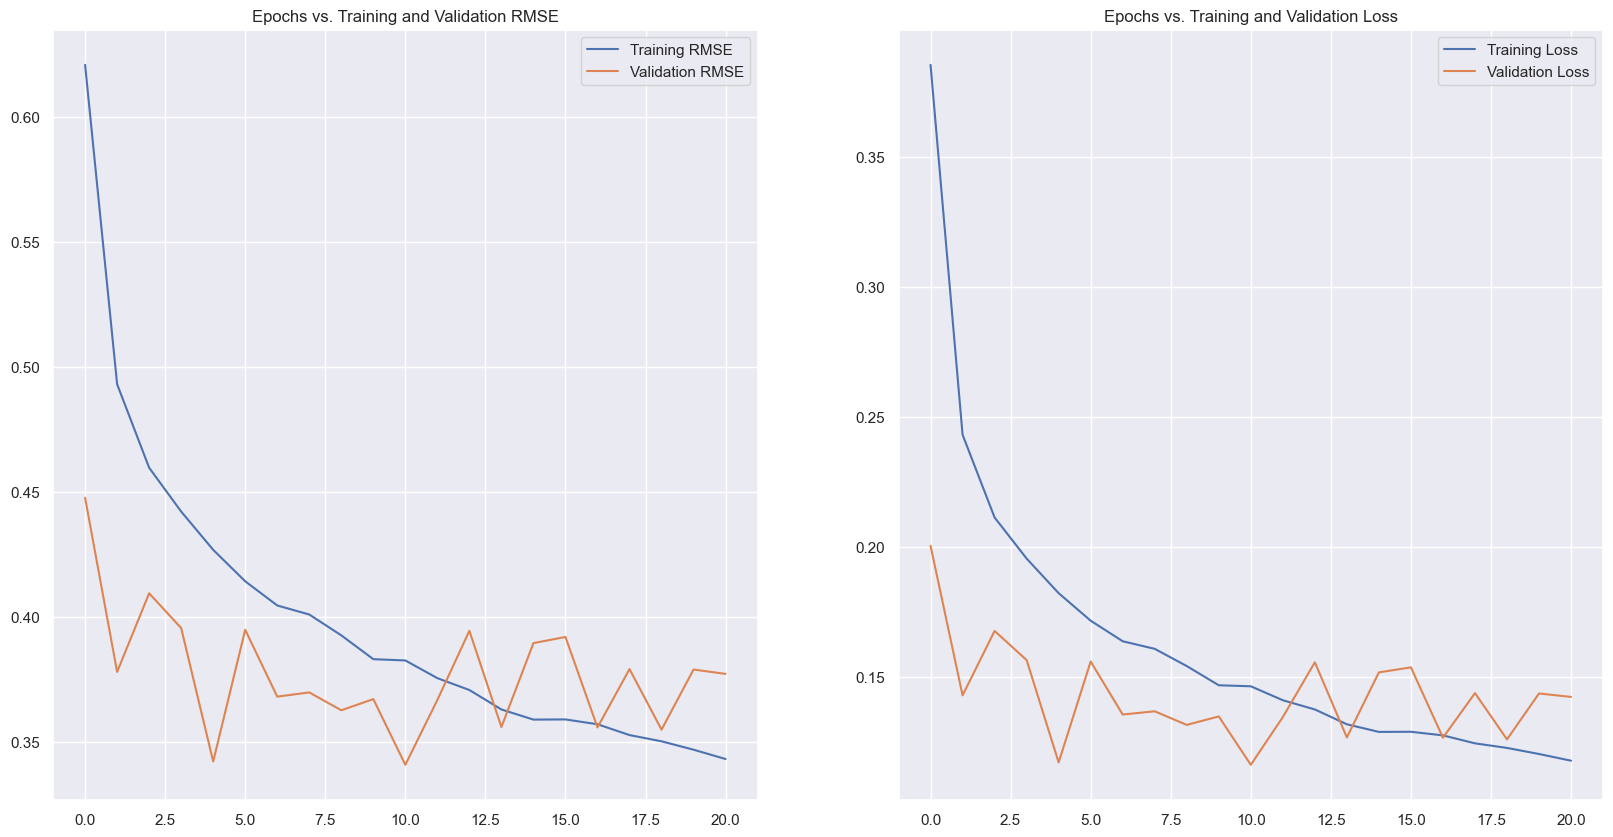

In [108]:
plot_results(history_13)

---
### (14) Create new LSTM model based on previous performance
---

In [109]:
# Changes to model_LSTM_13
# increase first Dropout(16) rate 0.3->0.4

In [110]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_14 = Sequential()
model_LSTM_14.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_14.add(LSTM(32, return_sequences=True))
model_LSTM_14.add(LSTM(16))
model_LSTM_14.add(Flatten())
model_LSTM_14.add(Dense(16, activation='tanh'))
model_LSTM_14.add(Dropout(0.4))
model_LSTM_14.add(Dense(8, activation='relu'))
model_LSTM_14.add(Dropout(0.2))
model_LSTM_14.add(Dense(1))
model_LSTM_14.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [111]:
# Train the model
history_14 = model_LSTM_14.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 41s 45ms/step - loss: 0.3997 - root_mean_squared_error: 0.6322 - accuracy: 0.0000e+00 - val_loss: 0.1937 - val_root_mean_squared_error: 0.4401 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 27s 40ms/step - loss: 0.2628 - root_mean_squared_error: 0.5126 - accuracy: 0.0000e+00 - val_loss: 0.1631 - val_root_mean_squared_error: 0.4039 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 26s 39ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792 - accuracy: 0.0000e+00 - val_loss: 0.1469 - val_root_mean_squared_error: 0.3833 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 23s 34ms/step - loss: 0.2059 - root_mean_squared_error: 0.4538 - accuracy: 0.0000e+00 - val_loss: 0.1313 - val_root_mean_squared_error: 0.3624 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 19s 27ms/step - loss: 0.1952 - root_mean_squared_e

In [112]:
save_model_and_training_history(
    model_LSTM_14,
    f'{model_LSTM_14=}'.split('=')[0],
    history_14
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_14.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_14.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.39973974227905273, 0.2627936005592346, 0.22964949905872345, 0.20589803159236908, 0.19516190886497498, 0.18057753145694733, 0.17789264023303986, 0.16900520026683807, 0.1625596284866333, 0.15810509026050568, 0.15513575077056885, 0.1475069373846054, 0.14435939490795135, 0.1419426053762436, 0.13914011418819427, 0.13730210065841675, 0.13157016038894653, 0.13185033202171326, 0.12915463745594025]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.19365350902080536, 0.16313689947128296, 0.14688226580619812, 0.13133062422275543, 0.16304172575473785, 0.12466226518154144, 0.15180668234825134, 0.13036057353019714, 0.11818061769008636, 0.13722896575927734, 0.16331243515014648, 0.13709256052970886, 0.1269906759262085, 0.14621052145957947, 0.1273556351661682, 0.12868614494800568, 0.13093626499176025, 0.13293242454528809, 0.12205318361520767]
history.h

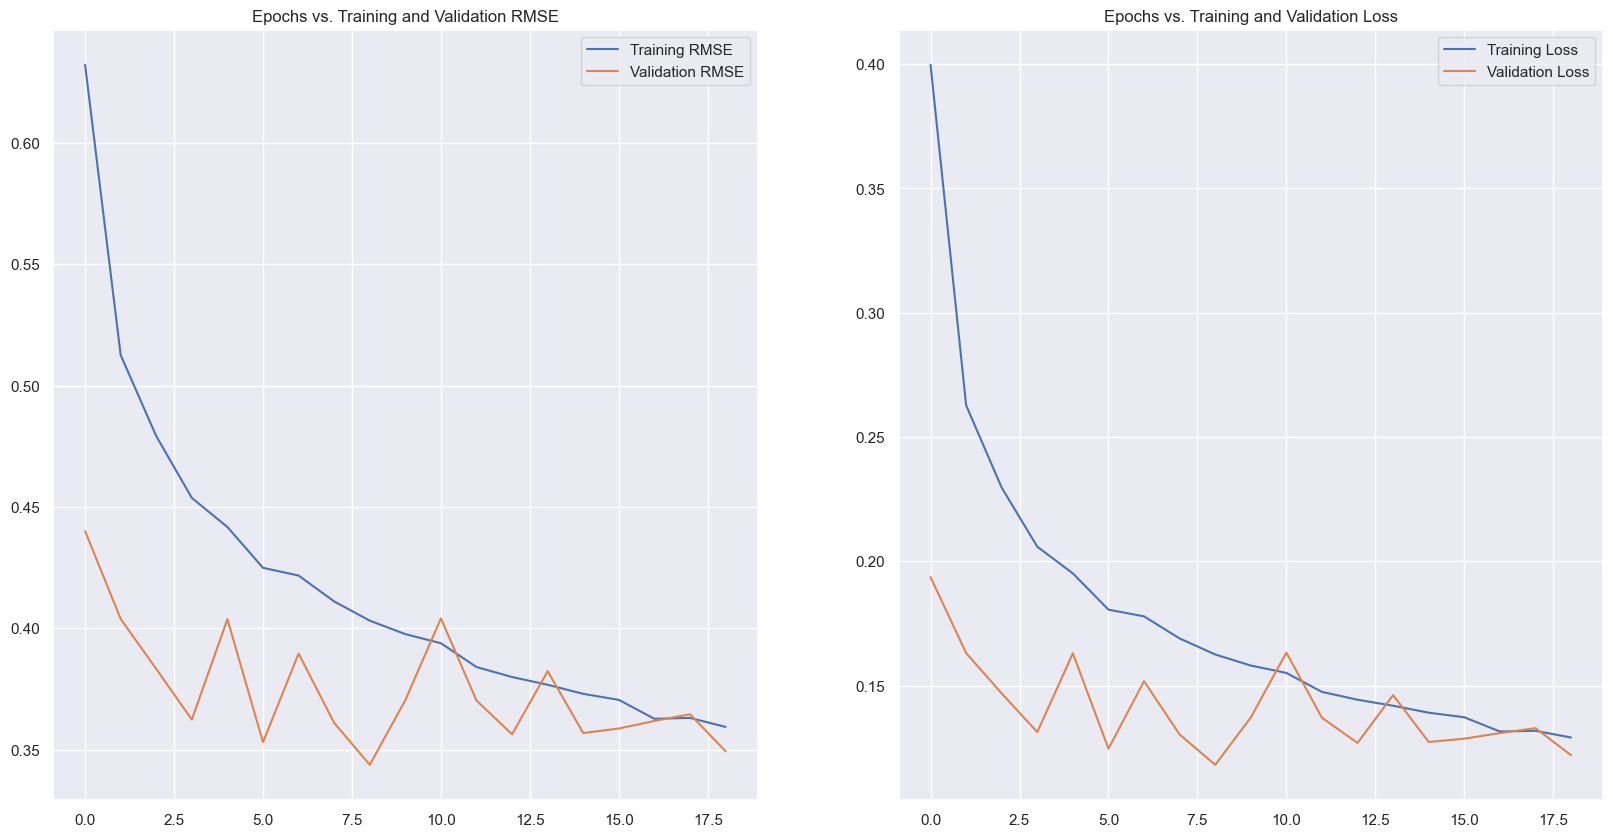

In [113]:
plot_results(history_14)

---
### (15) Create new LSTM model based on previous performance
---

In [114]:
# Changes to model_LSTM_14
# change activation function in Dense(16) layer from tanh to relu

In [115]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_15 = Sequential()
model_LSTM_15.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_15.add(LSTM(32, return_sequences=True))
model_LSTM_15.add(LSTM(16))
model_LSTM_15.add(Flatten())
model_LSTM_15.add(Dense(16, activation='relu'))
model_LSTM_15.add(Dropout(0.4))
model_LSTM_15.add(Dense(8, activation='relu'))
model_LSTM_15.add(Dropout(0.2))
model_LSTM_15.add(Dense(1))
model_LSTM_15.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [116]:
# Train the model
history_15 = model_LSTM_15.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 32s 34ms/step - loss: 0.4290 - root_mean_squared_error: 0.6550 - accuracy: 0.0000e+00 - val_loss: 0.2294 - val_root_mean_squared_error: 0.4789 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 19s 29ms/step - loss: 0.2737 - root_mean_squared_error: 0.5231 - accuracy: 0.0000e+00 - val_loss: 0.2187 - val_root_mean_squared_error: 0.4676 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 15s 22ms/step - loss: 0.2351 - root_mean_squared_error: 0.4849 - accuracy: 0.0000e+00 - val_loss: 0.1535 - val_root_mean_squared_error: 0.3918 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 14s 20ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658 - accuracy: 0.0000e+00 - val_loss: 0.1900 - val_root_mean_squared_error: 0.4359 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 14s 21ms/step - loss: 0.2036 - root_mean_squared_e

In [117]:
save_model_and_training_history(
    model_LSTM_15,
    f'{model_LSTM_15=}'.split('=')[0],
    history_15
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_15.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_15.pkl


History statistics: 
history.history['loss']=[0.4289821684360504, 0.2736659646034241, 0.2351164072751999, 0.21700291335582733, 0.20359450578689575, 0.19318166375160217, 0.18479302525520325, 0.17757394909858704, 0.17297245562076569, 0.16708216071128845, 0.16261275112628937, 0.16330759227275848, 0.15594005584716797, 0.1491938978433609, 0.15057671070098877, 0.15025240182876587, 0.14561541378498077, 0.14094051718711853, 0.14532311260700226, 0.14168964326381683, 0.1375502198934555, 0.137350395321846, 0.1348152458667755, 0.1359356790781021, 0.13480748236179352, 0.13410121202468872, 0.1303335726261139, 0.1334991157054901, 0.13319963216781616, 0.12895631790161133, 0.12795016169548035]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.2293882817029953, 0.21866658329963684, 0.15354156494140625, 0.19004148244857788, 0.1498221307992935

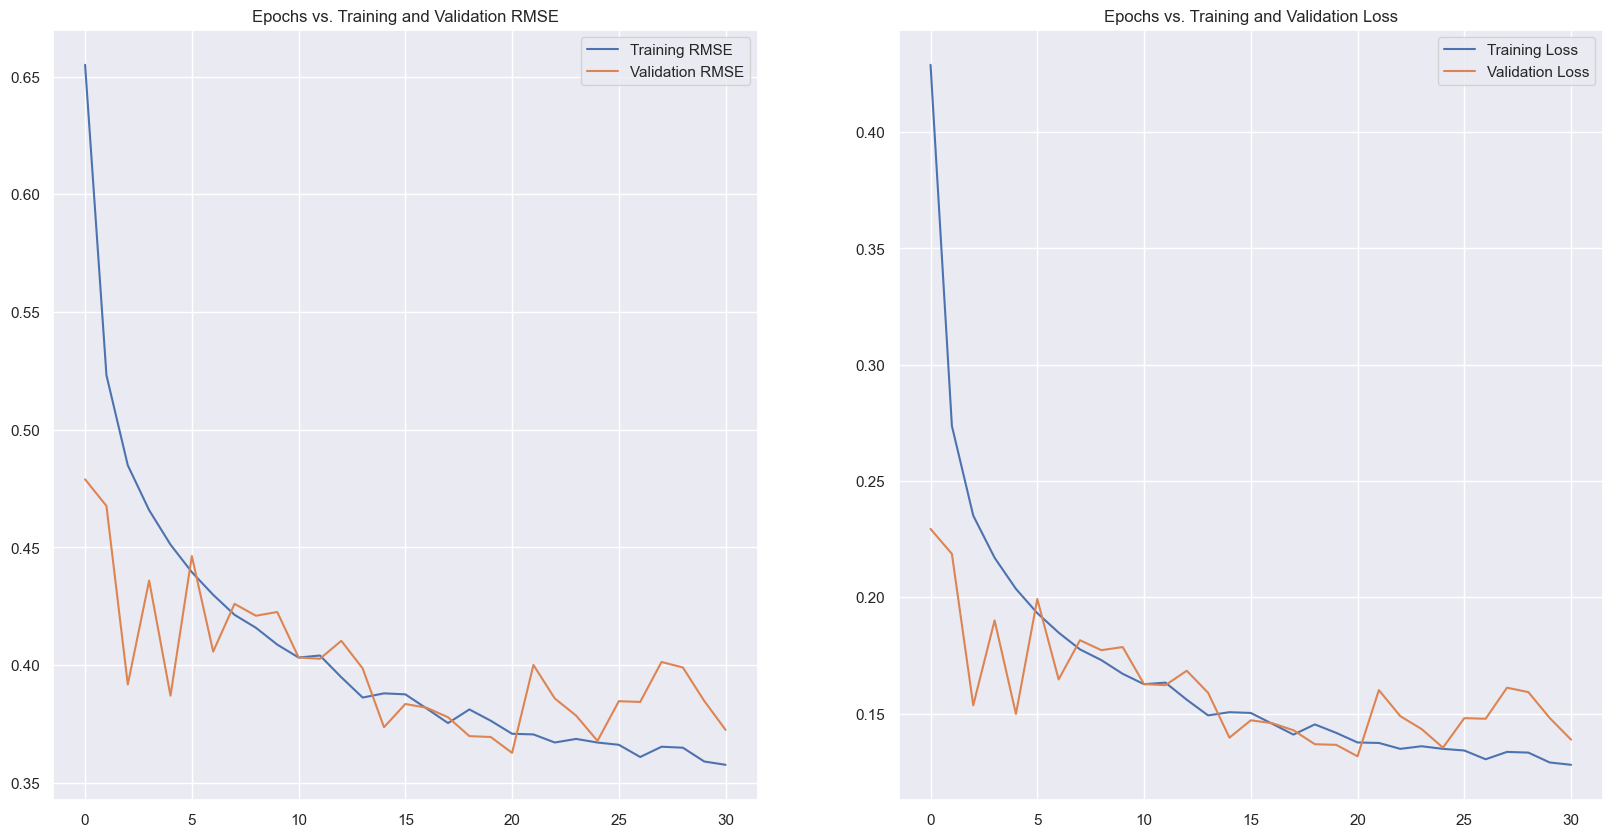

In [118]:
plot_results(history_15)

---
### (16) Create new LSTM model based on previous performance
---

In [119]:
# Changes to model_LSTM_15
# Add another LSTM(32) layer

In [120]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_16 = Sequential()
model_LSTM_16.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_16.add(LSTM(32, return_sequences=True))
model_LSTM_16.add(LSTM(32, return_sequences=True))
model_LSTM_16.add(LSTM(16))
model_LSTM_16.add(Flatten())
model_LSTM_16.add(Dense(16, activation='relu'))
model_LSTM_16.add(Dropout(0.4))
model_LSTM_16.add(Dense(8, activation='relu'))
model_LSTM_16.add(Dropout(0.2))
model_LSTM_16.add(Dense(1))
model_LSTM_16.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [121]:
# Train the model
history_16 = model_LSTM_16.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 31s 32ms/step - loss: 0.4889 - root_mean_squared_error: 0.6992 - accuracy: 0.0000e+00 - val_loss: 0.3052 - val_root_mean_squared_error: 0.5525 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 20s 30ms/step - loss: 0.3014 - root_mean_squared_error: 0.5490 - accuracy: 0.0000e+00 - val_loss: 0.2066 - val_root_mean_squared_error: 0.4545 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 21s 31ms/step - loss: 0.2568 - root_mean_squared_error: 0.5068 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_root_mean_squared_error: 0.4310 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 20s 30ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758 - accuracy: 0.0000e+00 - val_loss: 0.2163 - val_root_mean_squared_error: 0.4651 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 20s 30ms/step - loss: 0.2121 - root_mean_squared_e

In [122]:
save_model_and_training_history(
    model_LSTM_16,
    f'{model_LSTM_16=}'.split('=')[0],
    history_16
)

C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model as train_session__20231127_000227/models/chckp__model_LSTM_16.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_16.pkl


History statistics: 
history.history['loss']=[0.4889286458492279, 0.3013642430305481, 0.25684085488319397, 0.2263612002134323, 0.21213304996490479, 0.2008737027645111, 0.1885697990655899, 0.182150200009346, 0.17743588984012604, 0.17060332000255585, 0.16422539949417114, 0.16217373311519623, 0.1590786874294281, 0.15552175045013428, 0.15515586733818054, 0.14758124947547913, 0.14605671167373657, 0.1443900465965271, 0.14140763878822327]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.305237352848053, 0.2065524458885193, 0.18573500216007233, 0.21630895137786865, 0.15808513760566711, 0.13943864405155182, 0.17977482080459595, 0.13054706156253815, 0.12746436893939972, 0.1426755040884018, 0.13603591918945312, 0.14963999390602112, 0.1364419311285019, 0.13760899007320404, 0.14396807551383972, 0.1398264467716217, 0.1298305243253708, 0.14041189849376678, 0.14549006521701813]
history.history['va

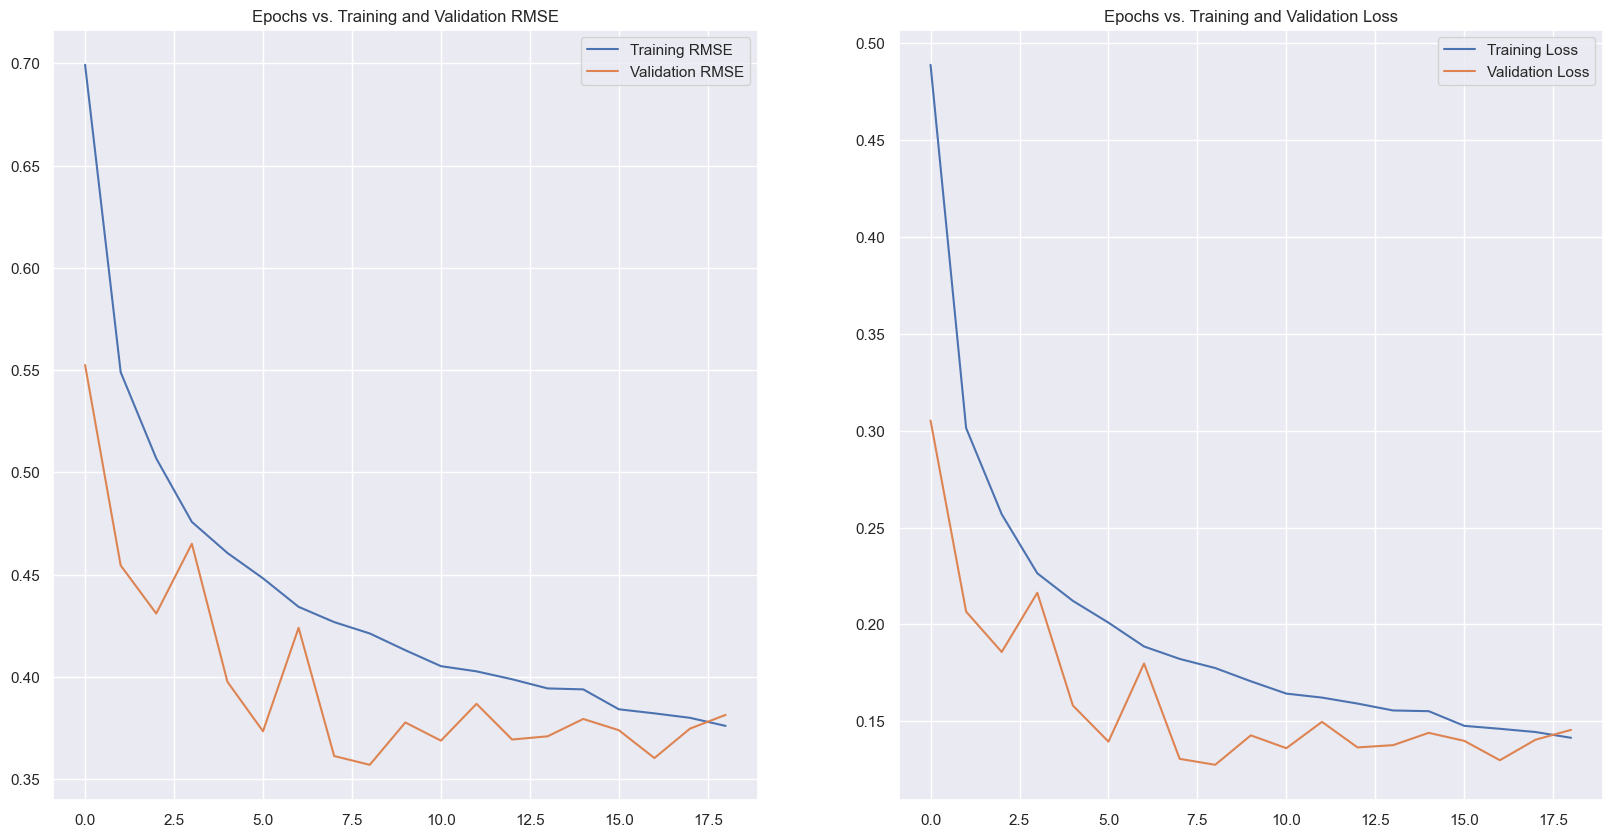

In [123]:
plot_results(history_16)

---
### (17) Create new LSTM model based on previous performance
---

In [124]:
# Changes to model_LSTM_15
# decrese cells in second LSTM layer to 16

In [125]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_17 = Sequential()
model_LSTM_17.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_17.add(LSTM(16, return_sequences=True))
model_LSTM_17.add(LSTM(16))
model_LSTM_17.add(Flatten())
model_LSTM_17.add(Dense(16, activation='relu'))
model_LSTM_17.add(Dropout(0.4))
model_LSTM_17.add(Dense(8, activation='relu'))
model_LSTM_17.add(Dropout(0.2))
model_LSTM_17.add(Dense(1))
model_LSTM_17.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [126]:
# Train the model
history_17 = model_LSTM_17.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 36s 35ms/step - loss: 0.4576 - root_mean_squared_error: 0.6764 - accuracy: 0.0000e+00 - val_loss: 0.2805 - val_root_mean_squared_error: 0.5296 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 20s 29ms/step - loss: 0.2976 - root_mean_squared_error: 0.5455 - accuracy: 0.0000e+00 - val_loss: 0.1923 - val_root_mean_squared_error: 0.4385 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 20s 29ms/step - loss: 0.2568 - root_mean_squared_error: 0.5068 - accuracy: 0.0000e+00 - val_loss: 0.1595 - val_root_mean_squared_error: 0.3994 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 20s 29ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856 - accuracy: 0.0000e+00 - val_loss: 0.1570 - val_root_mean_squared_error: 0.3962 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 20s 29ms/step - loss: 0.2215 - root_mean_squared_e

In [127]:
save_model_and_training_history(
    model_LSTM_17,
    f'{model_LSTM_17=}'.split('=')[0],
    history_17
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_17.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_17.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.4575769007205963, 0.29757773876190186, 0.25684210658073425, 0.2357800453901291, 0.22153130173683167, 0.2075786292552948, 0.20023413002490997, 0.19257284700870514, 0.18984980881214142, 0.18425212800502777, 0.17850208282470703, 0.1696849763393402, 0.1679048091173172, 0.16659846901893616, 0.1600591540336609, 0.1611173152923584, 0.15432626008987427, 0.15815705060958862, 0.15649069845676422, 0.1510838270187378, 0.15270593762397766, 0.14808641374111176]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.28050675988197327, 0.19226036965847015, 0.15951286256313324, 0.15697529911994934, 0.1701388955116272, 0.16020864248275757, 0.13183936476707458, 0.16373871266841888, 0.15561388432979584, 0.1441756933927536, 0.13079386949539185, 0.10999101400375366, 0.15058760344982147, 0.13313256204128265, 0.17716683447360992, 0.13134707510471344

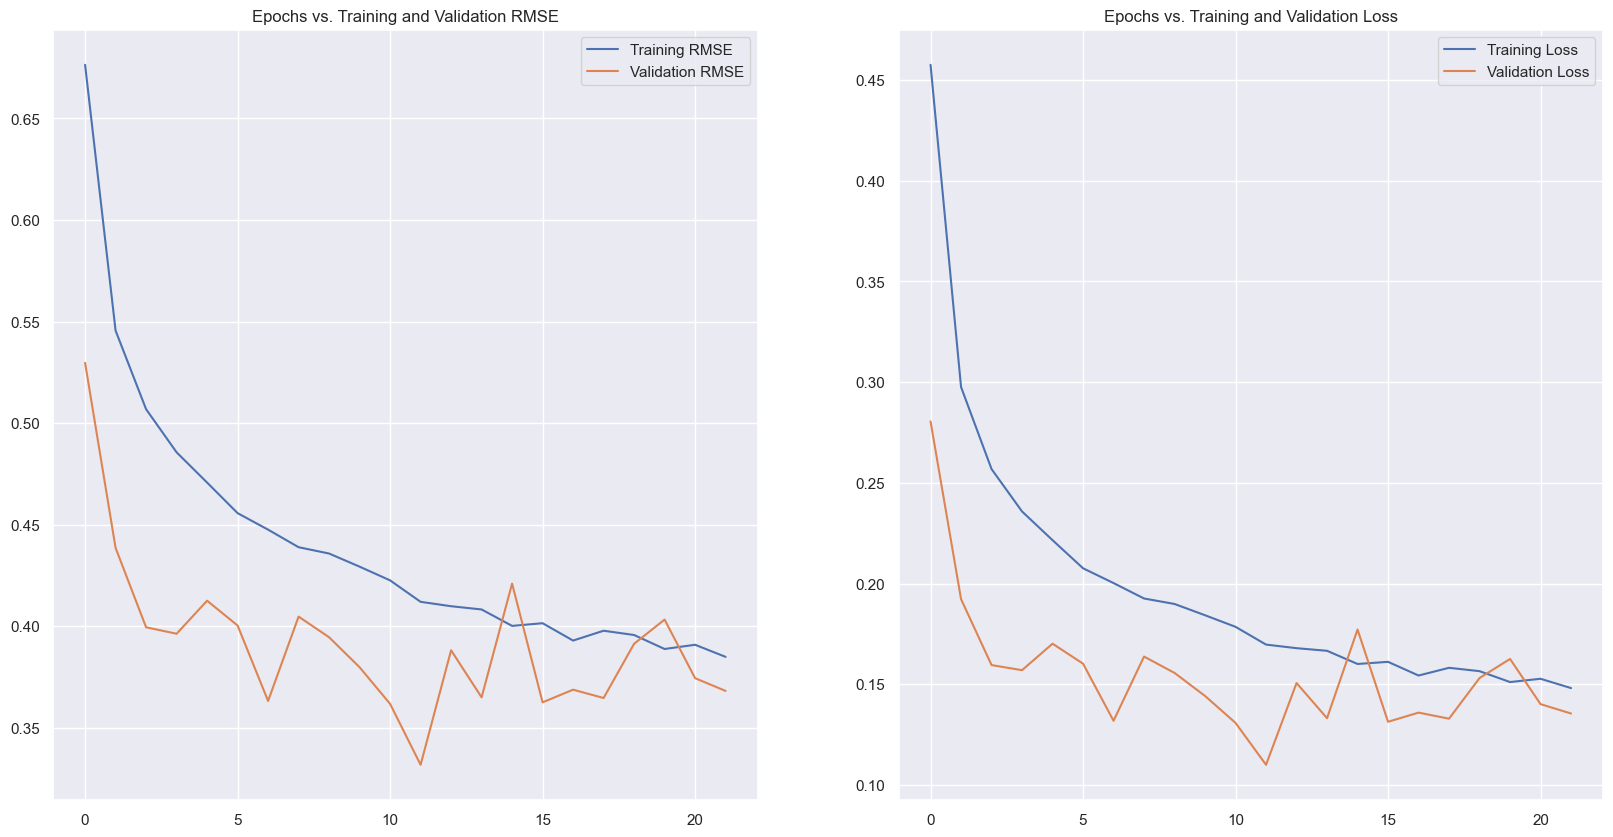

In [128]:
plot_results(history_17)

---
### (18) Create new LSTM model based on previous performance
---

In [129]:
# Changes to model_LSTM_15
# decrese cells in second LSTM layer to 16
# increase Dropout layer rate 0.2->0.3

In [130]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_18 = Sequential()
model_LSTM_18.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_18.add(LSTM(16, return_sequences=True))
model_LSTM_18.add(LSTM(16))
model_LSTM_18.add(Flatten())
model_LSTM_18.add(Dense(16, activation='relu'))
model_LSTM_18.add(Dropout(0.4))
model_LSTM_18.add(Dense(8, activation='relu'))
model_LSTM_18.add(Dropout(0.3))
model_LSTM_18.add(Dense(1))
model_LSTM_18.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [131]:
# Train the model
history_18 = model_LSTM_18.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 20s 19ms/step - loss: 0.4923 - root_mean_squared_error: 0.7016 - accuracy: 0.0000e+00 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 14s 21ms/step - loss: 0.3218 - root_mean_squared_error: 0.5672 - accuracy: 0.0000e+00 - val_loss: 0.1791 - val_root_mean_squared_error: 0.4232 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 12s 17ms/step - loss: 0.2887 - root_mean_squared_error: 0.5373 - accuracy: 0.0000e+00 - val_loss: 0.1881 - val_root_mean_squared_error: 0.4337 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 10s 15ms/step - loss: 0.2633 - root_mean_squared_error: 0.5131 - accuracy: 0.0000e+00 - val_loss: 0.1544 - val_root_mean_squared_error: 0.3930 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 10s 15ms/step - loss: 0.2540 - root_mean_squared_e

In [132]:
save_model_and_training_history(
    model_LSTM_18,
    f'{model_LSTM_18=}'.split('=')[0],
    history_18
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_18.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_18.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.4922739863395691, 0.32176339626312256, 0.2886958420276642, 0.2632659673690796, 0.25396981835365295, 0.2439328134059906, 0.23793001472949982, 0.22499139606952667, 0.22291682660579681, 0.21961206197738647, 0.21320965886116028, 0.21317650377750397, 0.20655450224876404, 0.19935044646263123, 0.1991790533065796, 0.19879873096942902, 0.19491201639175415, 0.1906079649925232, 0.19378621876239777, 0.18579652905464172, 0.18527191877365112, 0.18543052673339844]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.2518850266933441, 0.17909683287143707, 0.18811315298080444, 0.15444867312908173, 0.16996261477470398, 0.15598101913928986, 0.14135901629924774, 0.1565050184726715, 0.15331126749515533, 0.14711415767669678, 0.16283471882343292, 0.13317377865314484, 0.13436222076416016, 0.1470400094985962, 0.15643225610256195, 0.1570598483085632

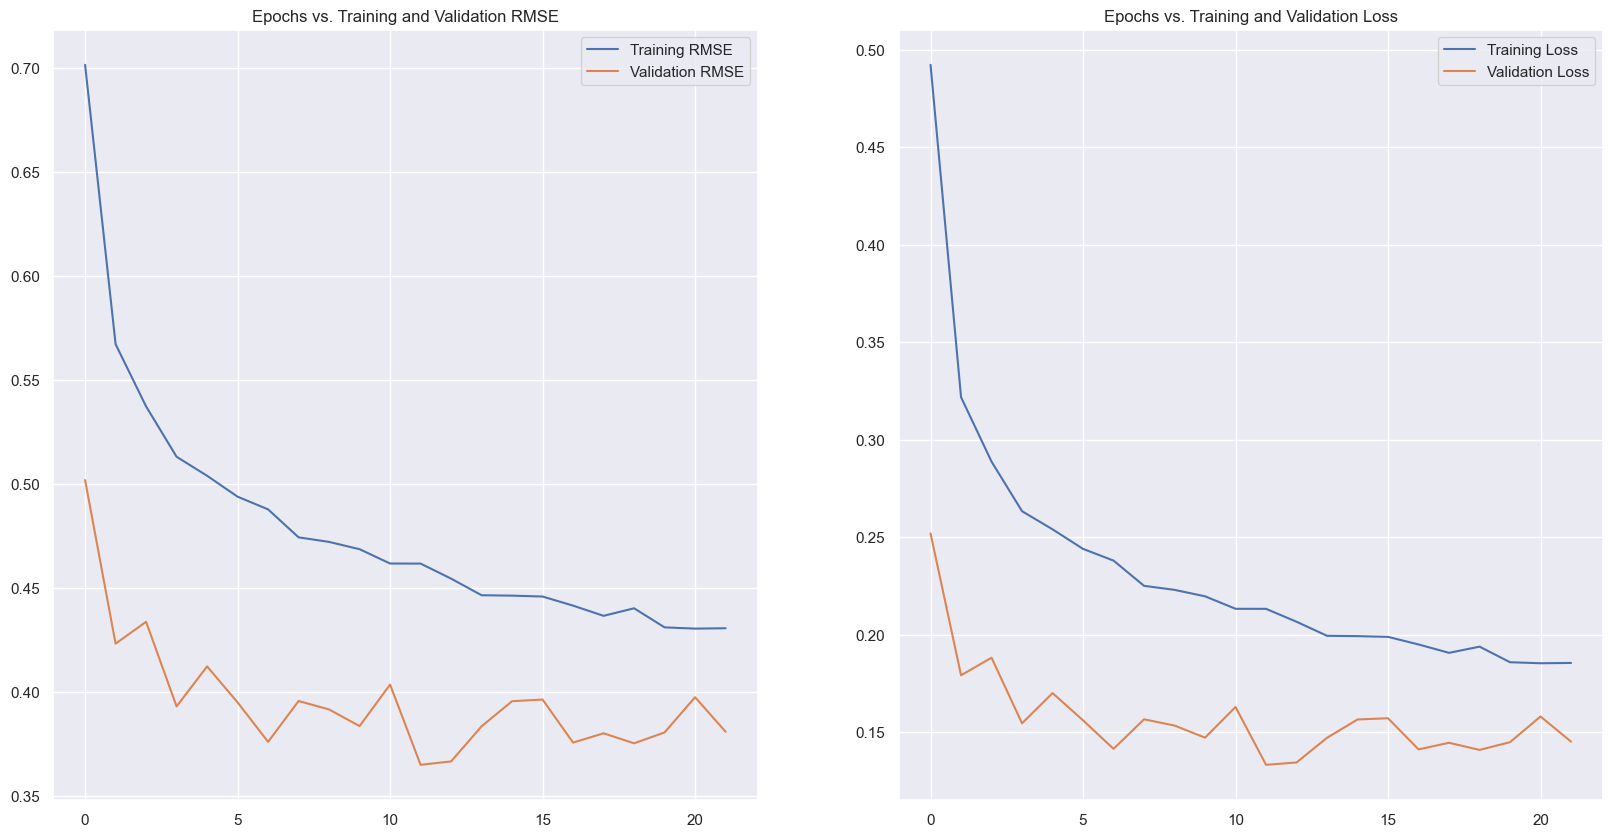

In [133]:
plot_results(history_18)

---
### (19) Create new LSTM model based on previous performance
---

In [134]:
# Changes to model_LSTM_15
# Increase Dense first layer size to 32

In [135]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_19 = Sequential()
model_LSTM_19.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_19.add(LSTM(32, return_sequences=True))
model_LSTM_19.add(LSTM(16))
model_LSTM_19.add(Flatten())
model_LSTM_19.add(Dense(32, activation='relu'))
model_LSTM_19.add(Dropout(0.4))
model_LSTM_19.add(Dense(8, activation='relu'))
model_LSTM_19.add(Dropout(0.2))
model_LSTM_19.add(Dense(1))
model_LSTM_19.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [136]:
# Train the model
history_19 = model_LSTM_19.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 26s 24ms/step - loss: 0.4118 - root_mean_squared_error: 0.6417 - accuracy: 0.0000e+00 - val_loss: 0.1893 - val_root_mean_squared_error: 0.4350 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 17s 25ms/step - loss: 0.2550 - root_mean_squared_error: 0.5050 - accuracy: 0.0000e+00 - val_loss: 0.1503 - val_root_mean_squared_error: 0.3877 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 15s 22ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718 - accuracy: 0.0000e+00 - val_loss: 0.1876 - val_root_mean_squared_error: 0.4331 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 17s 24ms/step - loss: 0.2020 - root_mean_squared_error: 0.4494 - accuracy: 0.0000e+00 - val_loss: 0.1393 - val_root_mean_squared_error: 0.3733 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 14s 21ms/step - loss: 0.1911 - root_mean_squared_e

In [137]:
save_model_and_training_history(
    model_LSTM_19,
    f'{model_LSTM_19=}'.split('=')[0],
    history_19
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_19.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_19.pkl


History statistics: 
history.history['loss']=[0.41182318329811096, 0.2549886405467987, 0.22261881828308105, 0.2019796222448349, 0.19112549722194672, 0.17843830585479736, 0.1705976128578186, 0.16477929055690765, 0.16140447556972504, 0.15457099676132202, 0.14913253486156464, 0.14791157841682434, 0.13893094658851624, 0.13611067831516266, 0.13243289291858673, 0.13250094652175903, 0.1312805414199829]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.1892518550157547, 0.15031975507736206, 0.18758238852024078, 0.13933122158050537, 0.16641810536384583, 0.1464180201292038, 0.11080045998096466, 0.13903193175792694, 0.1487116515636444, 0.13056795299053192, 0.1356159746646881, 0.14678779244422913, 0.14208859205245972, 0.11586788296699524, 0.16488875448703766, 0.13607874512672424, 0.11811011284589767]
history.history['val_accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

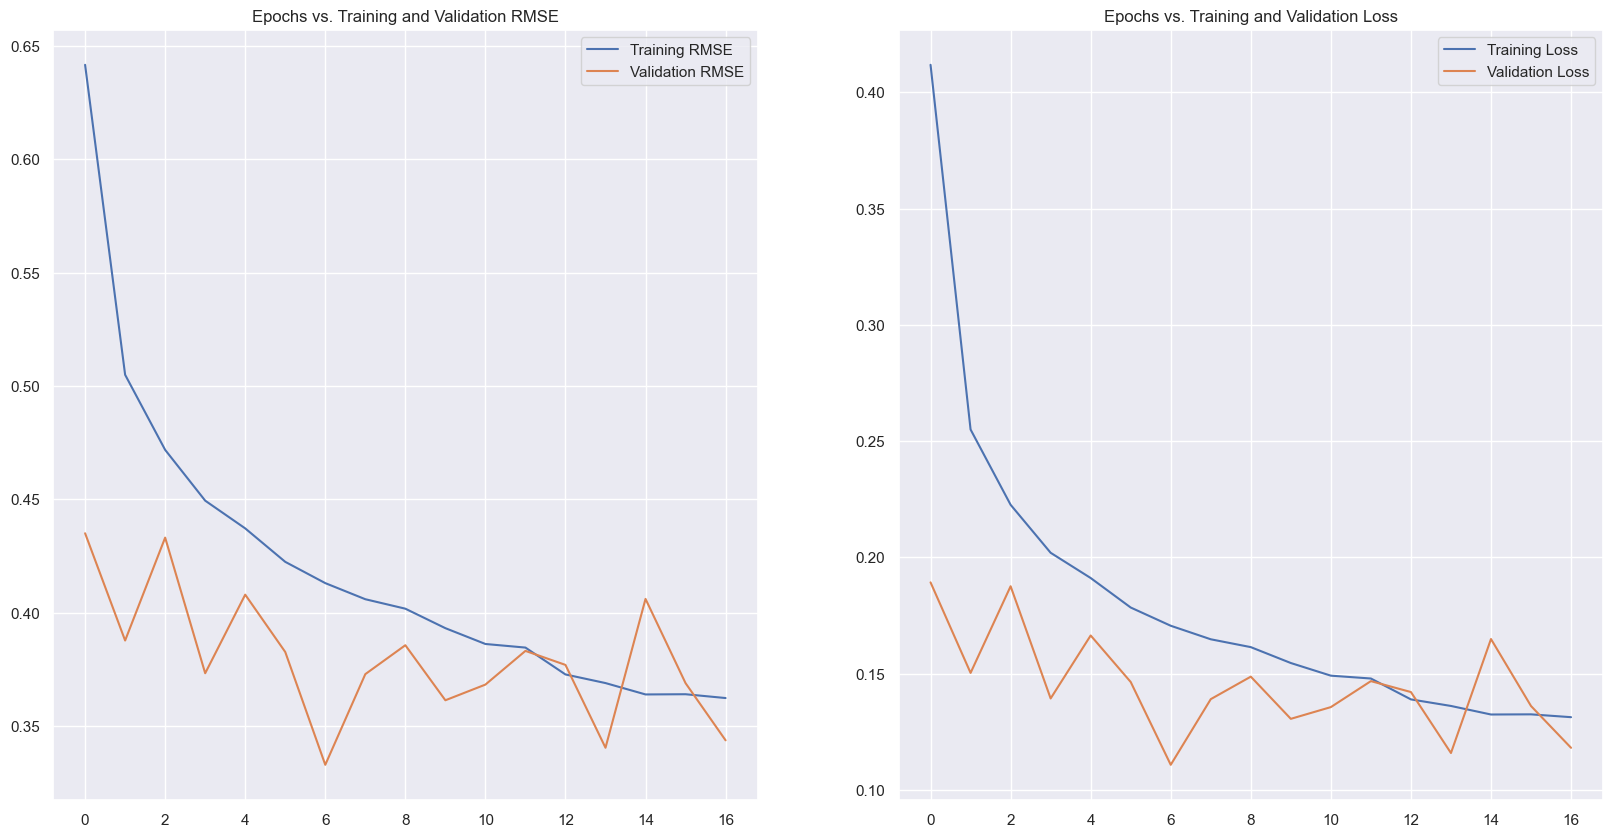

In [138]:
plot_results(history_19)

---
### (20) Create new LSTM model based on previous performance
---

In [139]:
# Changes to model_LSTM_...
# Increase Dense second layer size to 16

In [140]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_20 = Sequential()
model_LSTM_20.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_20.add(LSTM(32, return_sequences=True))
model_LSTM_20.add(LSTM(16))
model_LSTM_20.add(Flatten())
model_LSTM_20.add(Dense(16, activation='relu'))
model_LSTM_20.add(Dropout(0.4))
model_LSTM_20.add(Dense(16, activation='relu'))
model_LSTM_20.add(Dropout(0.2))
model_LSTM_20.add(Dense(1))
model_LSTM_20.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [141]:
# Train the model
history_20 = model_LSTM_20.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 32s 33ms/step - loss: 0.4053 - root_mean_squared_error: 0.6367 - accuracy: 0.0000e+00 - val_loss: 0.1962 - val_root_mean_squared_error: 0.4430 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 17s 25ms/step - loss: 0.2549 - root_mean_squared_error: 0.5048 - accuracy: 0.0000e+00 - val_loss: 0.2221 - val_root_mean_squared_error: 0.4713 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 18s 26ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586 - accuracy: 0.0000e+00 - val_loss: 0.1954 - val_root_mean_squared_error: 0.4421 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 17s 25ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328 - accuracy: 0.0000e+00 - val_loss: 0.2352 - val_root_mean_squared_error: 0.4850 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 16s 24ms/step - loss: 0.1732 - root_mean_squared_e

In [142]:
save_model_and_training_history(
    model_LSTM_20,
    f'{model_LSTM_20=}'.split('=')[0],
    history_20
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_20.h5


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_20.pkl


History statistics: 
history.history['loss']=[0.405327707529068, 0.25487226247787476, 0.21032385528087616, 0.1873023509979248, 0.17324098944664001, 0.1655472069978714, 0.15326069295406342, 0.14815428853034973, 0.14249621331691742, 0.13675619661808014, 0.13108153641223907, 0.12815439701080322, 0.12174881249666214, 0.11962370574474335, 0.11711427569389343, 0.11518245190382004, 0.11182436347007751, 0.10909079015254974, 0.10773751884698868, 0.10488556325435638, 0.1014019027352333, 0.09953044354915619, 0.09768267720937729, 0.09847588837146759, 0.09565410763025284, 0.09303586184978485, 0.09131114184856415, 0.08925236016511917, 0.09027525782585144, 0.09001580625772476, 0.08691757917404175, 0.08669595420360565, 0.0851454809308052, 0.08364549279212952, 0.08372879028320312, 0.0834154337644577, 0.0827852189540863, 0.08213125914335251, 0.08270354568958282, 0.08109906315803528, 0.0792941004037857, 0.07586710155010223, 0.07779950648546219, 0.07727682590484619, 0.0768146961927414, 0.0775502398610115,

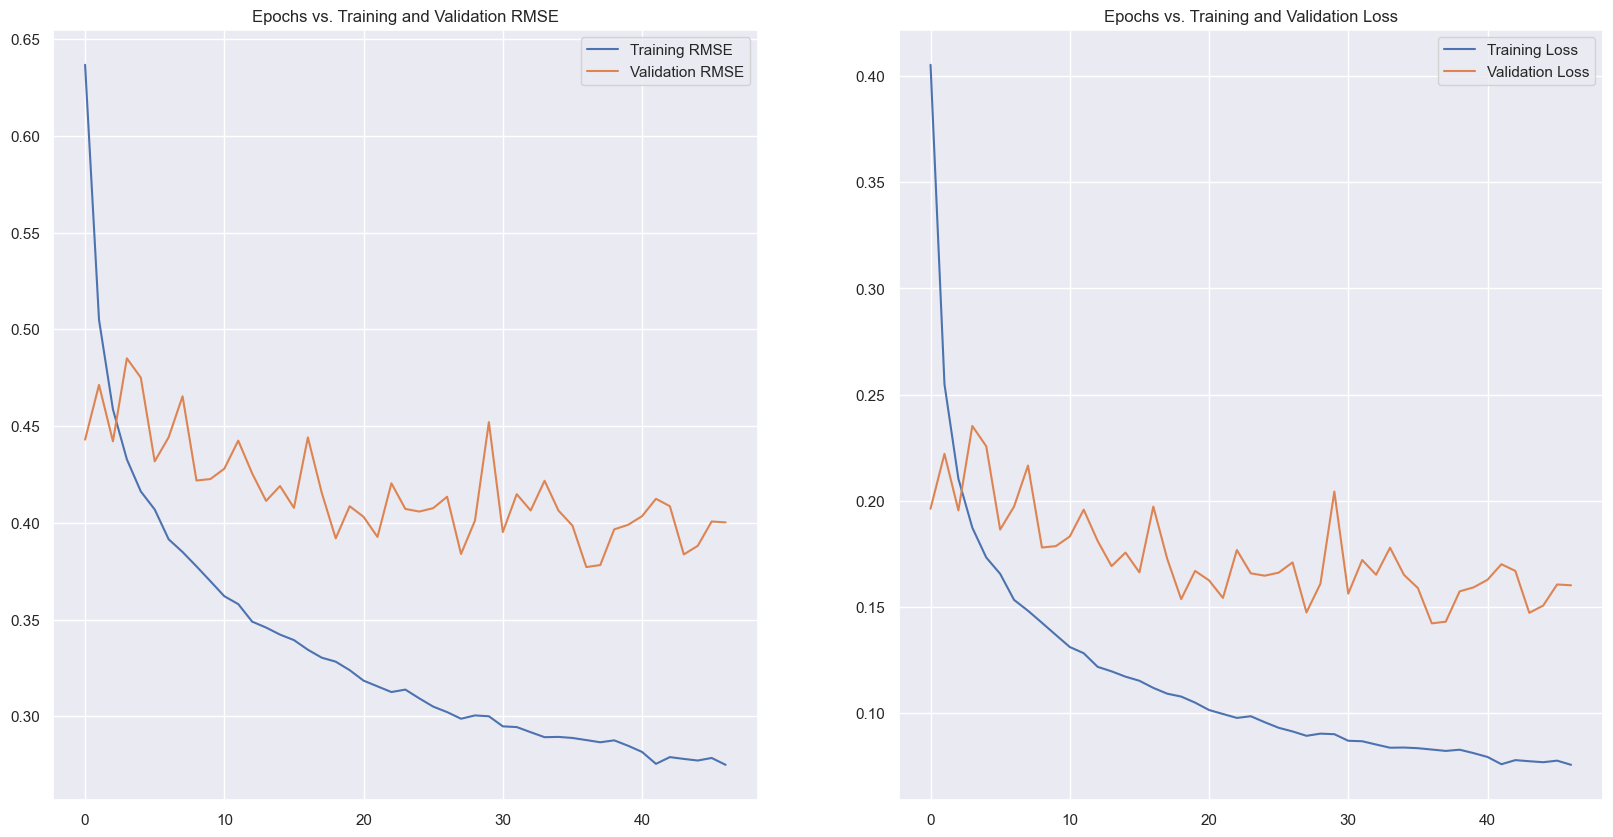

In [143]:
plot_results(history_20)

---
### (21) Create new LSTM model based on previous performance
---

In [ ]:
# Changes to model_LSTM_...
# Increase dropout second layer ratio 0.2->0.3 

In [144]:
# Create next LSTM model
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.Adam()

model_LSTM_21 = Sequential()
model_LSTM_21.add(LSTM(32, input_shape = X_train.shape[-2:], return_sequences=True))
model_LSTM_21.add(LSTM(32, return_sequences=True))
model_LSTM_21.add(LSTM(16))
model_LSTM_21.add(Flatten())
model_LSTM_21.add(Dense(16, activation='relu'))
model_LSTM_21.add(Dropout(0.4))
model_LSTM_21.add(Dense(16, activation='relu'))
model_LSTM_21.add(Dropout(0.3))
model_LSTM_21.add(Dense(1))
model_LSTM_21.compile(loss=loss, metrics=metric, optimizer=optimizer)

In [145]:
# Train the model
history_21 = model_LSTM_21.fit(X_train, y_train,
                             epochs=min_training_eval_epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/50
679/679 [==============================] - 17s 16ms/step - loss: 0.4360 - root_mean_squared_error: 0.6603 - accuracy: 0.0000e+00 - val_loss: 0.2437 - val_root_mean_squared_error: 0.4937 - val_accuracy: 0.0000e+00
Epoch 2/50
679/679 [==============================] - 11s 17ms/step - loss: 0.2814 - root_mean_squared_error: 0.5305 - accuracy: 0.0000e+00 - val_loss: 0.1886 - val_root_mean_squared_error: 0.4343 - val_accuracy: 0.0000e+00
Epoch 3/50
679/679 [==============================] - 11s 16ms/step - loss: 0.2442 - root_mean_squared_error: 0.4941 - accuracy: 0.0000e+00 - val_loss: 0.1802 - val_root_mean_squared_error: 0.4245 - val_accuracy: 0.0000e+00
Epoch 4/50
679/679 [==============================] - 11s 16ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662 - accuracy: 0.0000e+00 - val_loss: 0.1651 - val_root_mean_squared_error: 0.4063 - val_accuracy: 0.0000e+00
Epoch 5/50
679/679 [==============================] - 11s 16ms/step - loss: 0.2032 - root_mean_squared_e

In [146]:
save_model_and_training_history(
    model_LSTM_21,
    f'{model_LSTM_21=}'.split('=')[0],
    history_21
)

Saved model as train_session__20231127_000227/models/chckp__model_LSTM_21.h5
Saved training history as train_session__20231127_000227/histories/histr__model_LSTM_21.pkl


C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


History statistics: 
history.history['loss']=[0.4359973073005676, 0.2814399003982544, 0.2441755086183548, 0.21731849014759064, 0.20323653519153595, 0.19653743505477905, 0.1894969642162323, 0.1776215136051178, 0.1712304651737213, 0.16892026364803314, 0.16170383989810944, 0.15558657050132751, 0.15483425557613373, 0.1480151265859604, 0.1481565684080124, 0.1466694176197052, 0.14353179931640625, 0.14051391184329987, 0.13672927021980286, 0.13369467854499817, 0.1334453821182251, 0.13328488171100616, 0.13104288280010223, 0.12948399782180786, 0.12566034495830536, 0.12636052072048187, 0.1286567747592926, 0.12746180593967438, 0.12415700405836105, 0.12065418809652328, 0.12039625644683838, 0.11933416873216629, 0.12115734070539474]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.24372030794620514, 0.18864938616752625, 0.18021

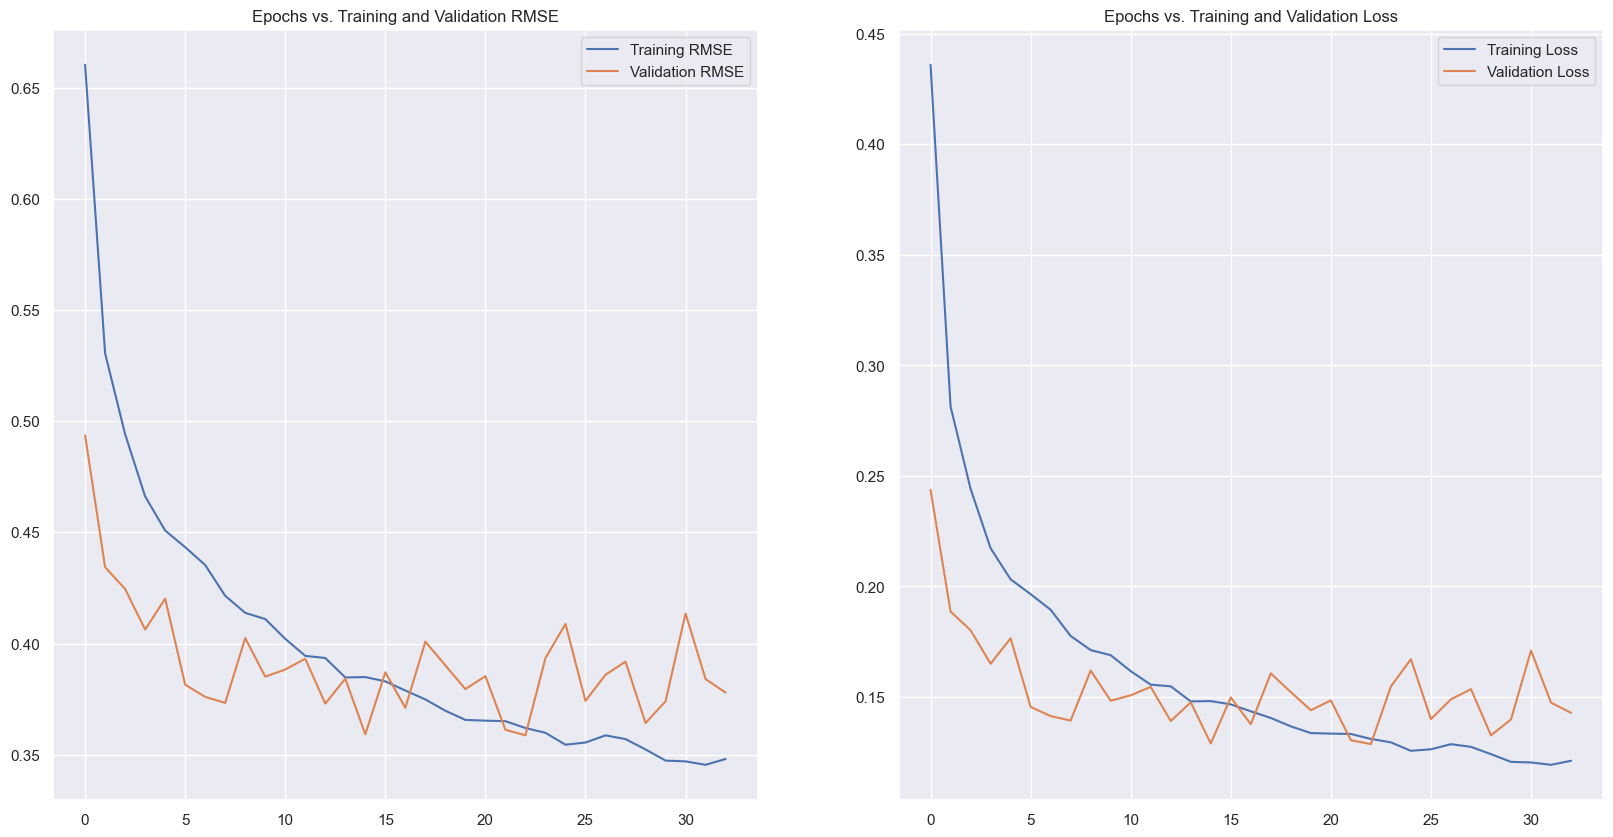

In [147]:
plot_results(history_21)

# Testowanie najlepszych modeli sieci

Model LSTM v21

In [20]:
from tensorflow.keras.models import load_model

# Replace 'path_to_model.h5' with your actual file path
model21 = load_model('/Users/bartosz/Downloads/projekt/train_session__20231127_000227/models/chckp__model_LSTM_21.h5')

352/352 [==============================] - 1s 3ms/step


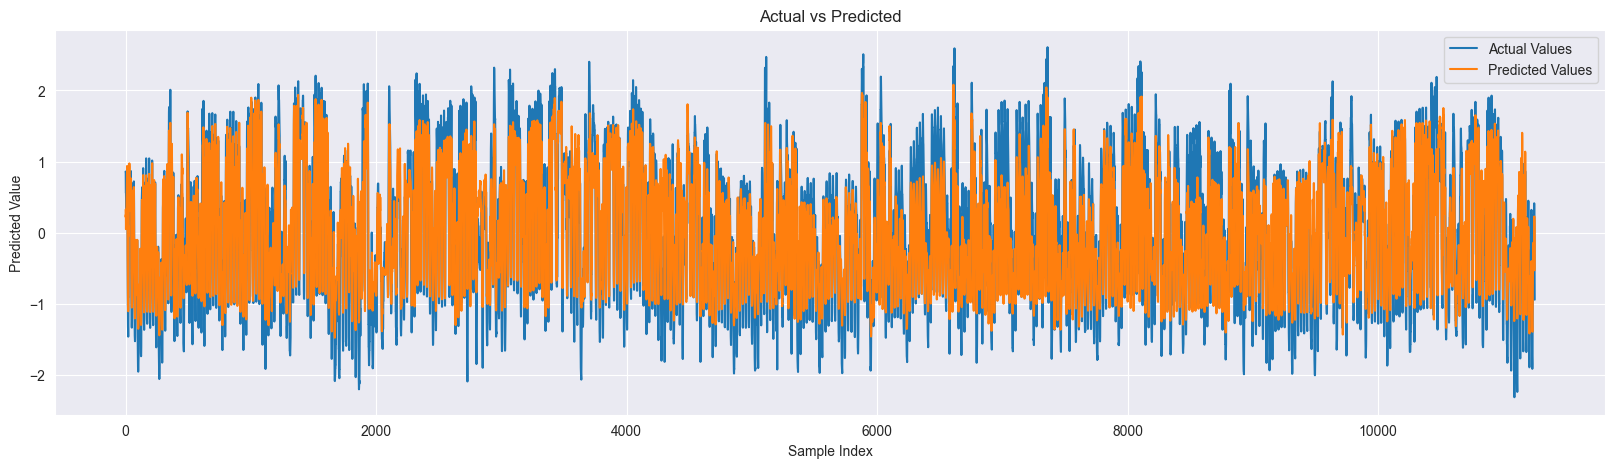

In [27]:
predictions = model21.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


352/352 [==============================] - 1s 3ms/step


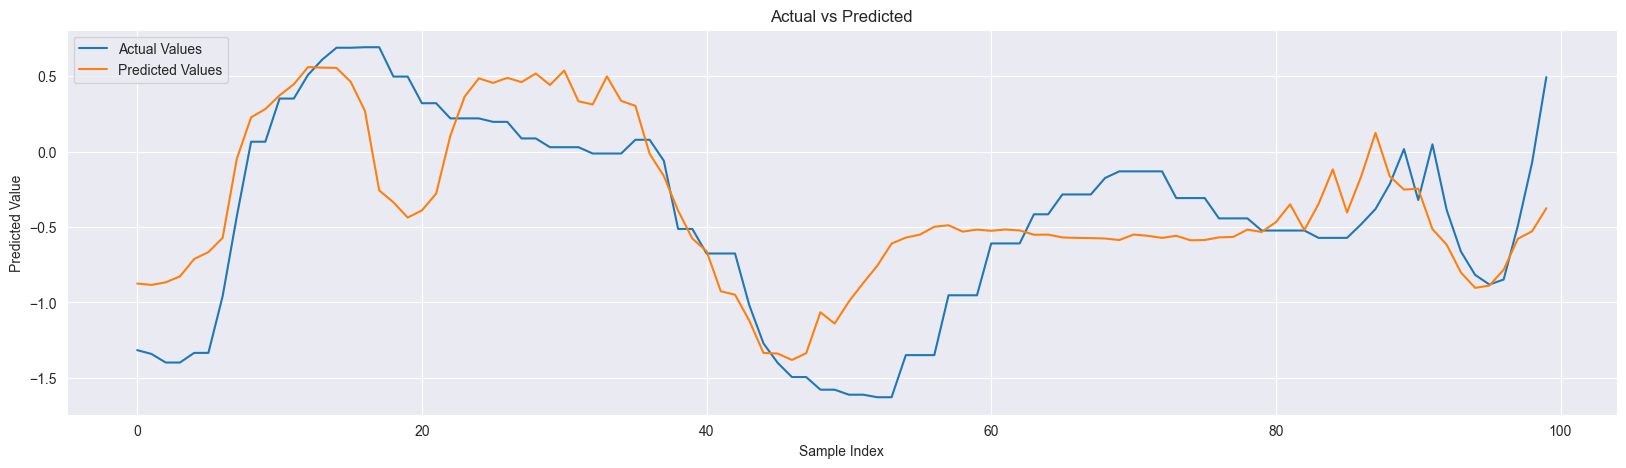

In [29]:
predictions = model21.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(y_test[2000:2100], label='Actual Values')
plt.plot(predictions[2000:2100], label='Predicted Values')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


Testowanie LSTM v15

In [21]:
from tensorflow.keras.models import load_model

model15 = load_model('/Users/bartosz/Downloads/projekt/train_session__20231127_000227/models/chckp__model_LSTM_15.h5')

352/352 [==============================] - 1s 1ms/step


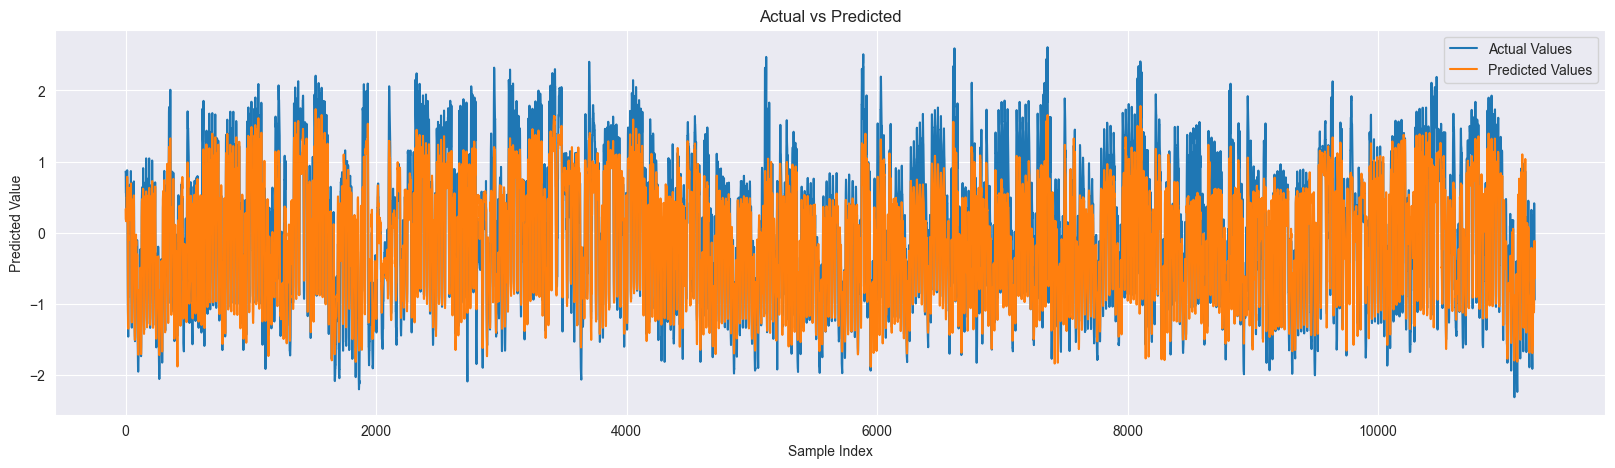

In [40]:
predictions = model15.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


352/352 [==============================] - 1s 2ms/step


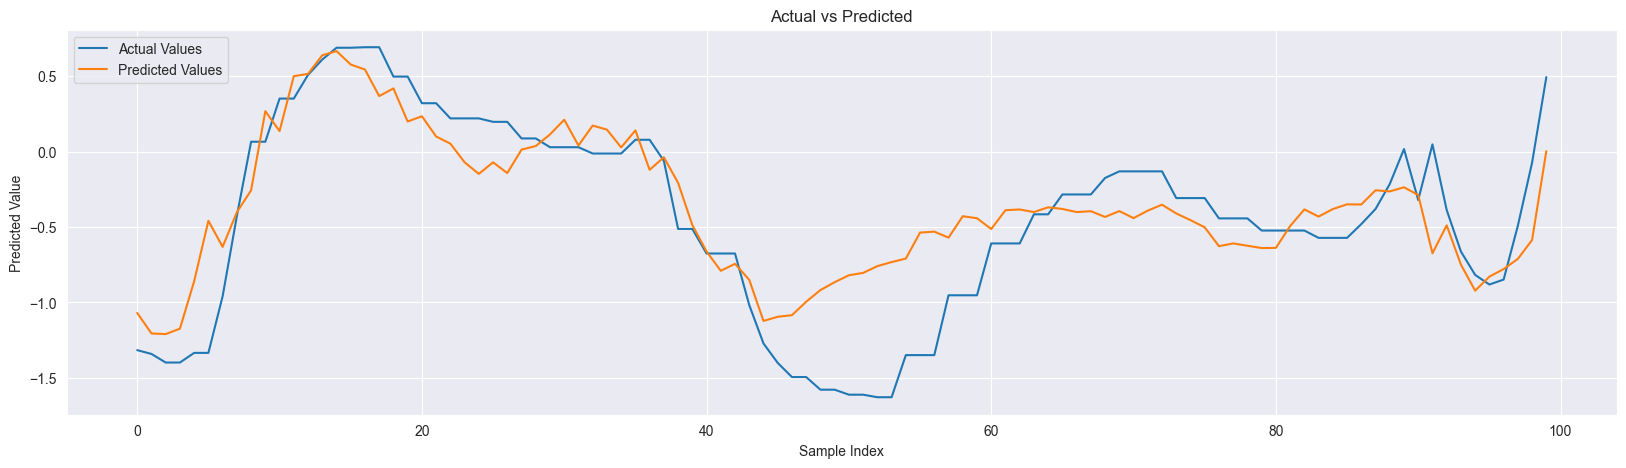

In [41]:
predictions = model15.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(y_test[2000:2100], label='Actual Values')
plt.plot(predictions[2000:2100], label='Predicted Values')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


# Testowanie najlepszego rozwiązania z poprzednich zajęć

Jak widać daje efekty znacznie gorsze niż model LSTM v21


In [22]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError(), 'accuracy']
optimizer = tf.keras.optimizers.legacy.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model_LSTM_5_old = Sequential()
model_LSTM_5_old.add(LSTM(100, input_shape = X_train.shape[-2:]))
model_LSTM_5_old.add(Flatten())
model_LSTM_5_old.add(Dense(180, activation='relu'))
model_LSTM_5_old.add(Dropout(0.1))
model_LSTM_5_old.add(Dense(1))
model_LSTM_5_old.compile(loss=loss, metrics=metric, optimizer=optimizer)

history_5_old = model_LSTM_5_old.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val),callbacks=[early_stopping])

Epoch 1/120
679/679 [==============================] - 4s 4ms/step - loss: 0.1898 - root_mean_squared_error: 0.4357 - accuracy: 0.0000e+00 - val_loss: 0.1663 - val_root_mean_squared_error: 0.4078 - val_accuracy: 0.0000e+00
Epoch 2/120
679/679 [==============================] - 3s 4ms/step - loss: 0.1203 - root_mean_squared_error: 0.3469 - accuracy: 0.0000e+00 - val_loss: 0.1503 - val_root_mean_squared_error: 0.3877 - val_accuracy: 0.0000e+00
Epoch 3/120
679/679 [==============================] - 2s 3ms/step - loss: 0.1010 - root_mean_squared_error: 0.3178 - accuracy: 0.0000e+00 - val_loss: 0.1356 - val_root_mean_squared_error: 0.3682 - val_accuracy: 0.0000e+00
Epoch 4/120
679/679 [==============================] - 2s 3ms/step - loss: 0.0846 - root_mean_squared_error: 0.2909 - accuracy: 0.0000e+00 - val_loss: 0.1261 - val_root_mean_squared_error: 0.3551 - val_accuracy: 0.0000e+00
Epoch 5/120
679/679 [==============================] - 2s 3ms/step - loss: 0.0702 - root_mean_squared_error:

History statistics: 
history.history['loss']=[0.1898496001958847, 0.12033791840076447, 0.10102691501379013, 0.08463529497385025, 0.07022213190793991, 0.06074473634362221, 0.053167618811130524, 0.04725731164216995, 0.042080022394657135, 0.038283444941043854, 0.03549019619822502, 0.03207458183169365, 0.03019094280898571, 0.028361709788441658, 0.026375314220786095, 0.0239714328199625, 0.023970089852809906, 0.022166907787322998]
history.history['accuracy']=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
history.history['val_loss']=[0.16627858579158783, 0.15027481317520142, 0.13556604087352753, 0.12608075141906738, 0.14369700849056244, 0.12166787683963776, 0.13116927444934845, 0.11807164549827576, 0.13540229201316833, 0.13423366844654083, 0.1362936794757843, 0.14853206276893616, 0.1248621717095375, 0.13930681347846985, 0.12248469144105911, 0.14333032071590424, 0.14821462333202362, 0.14646033942699432]
history.history['val_accuracy']=[0.0, 0.0, 0.0,

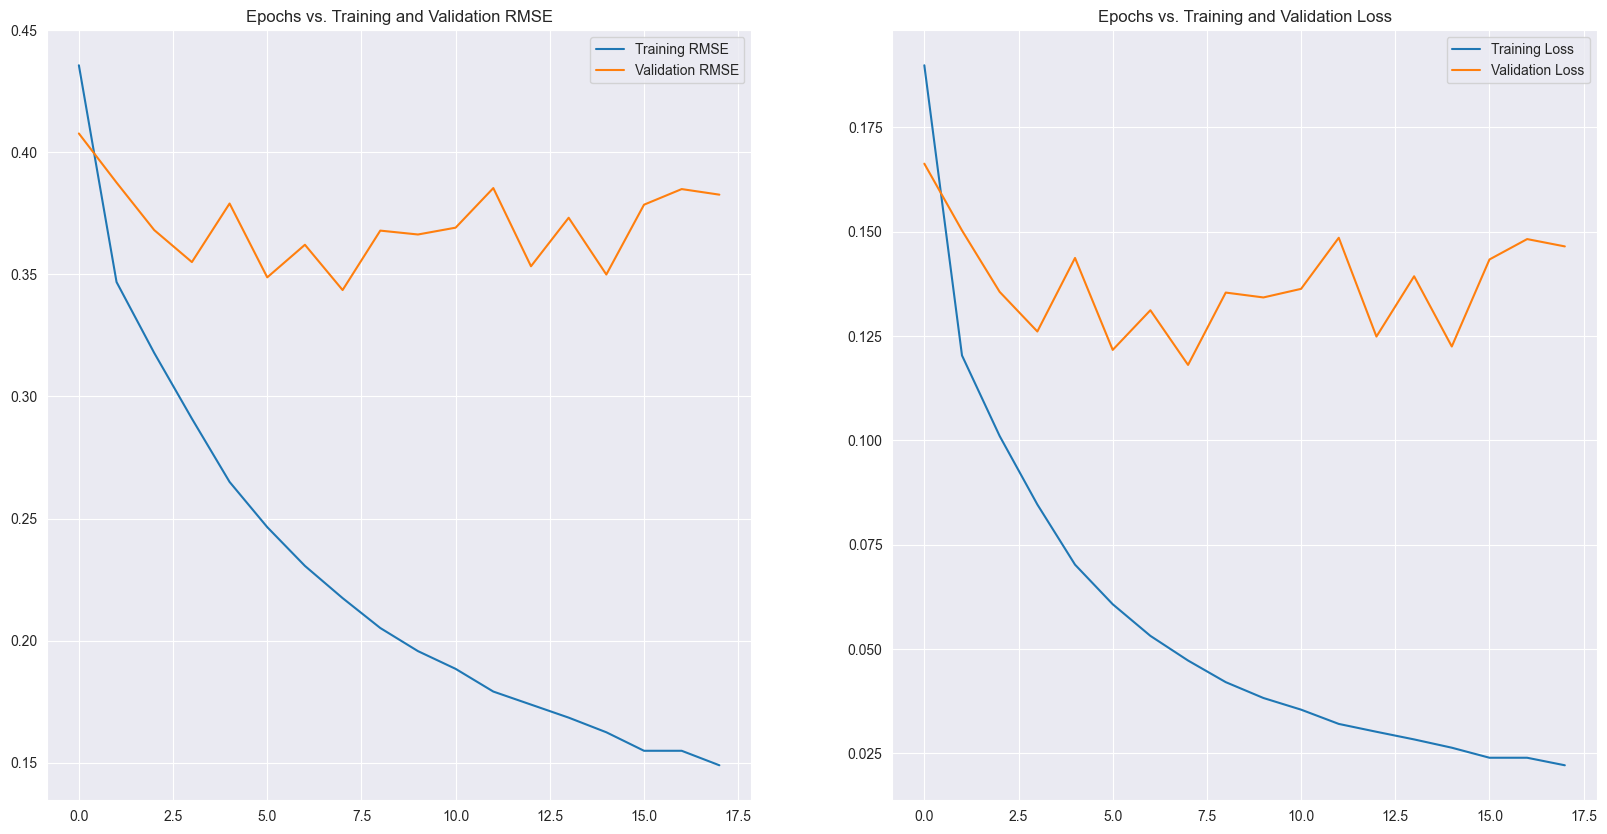

In [23]:
plot_results(history_5_old)


352/352 [==============================] - 1s 1ms/step


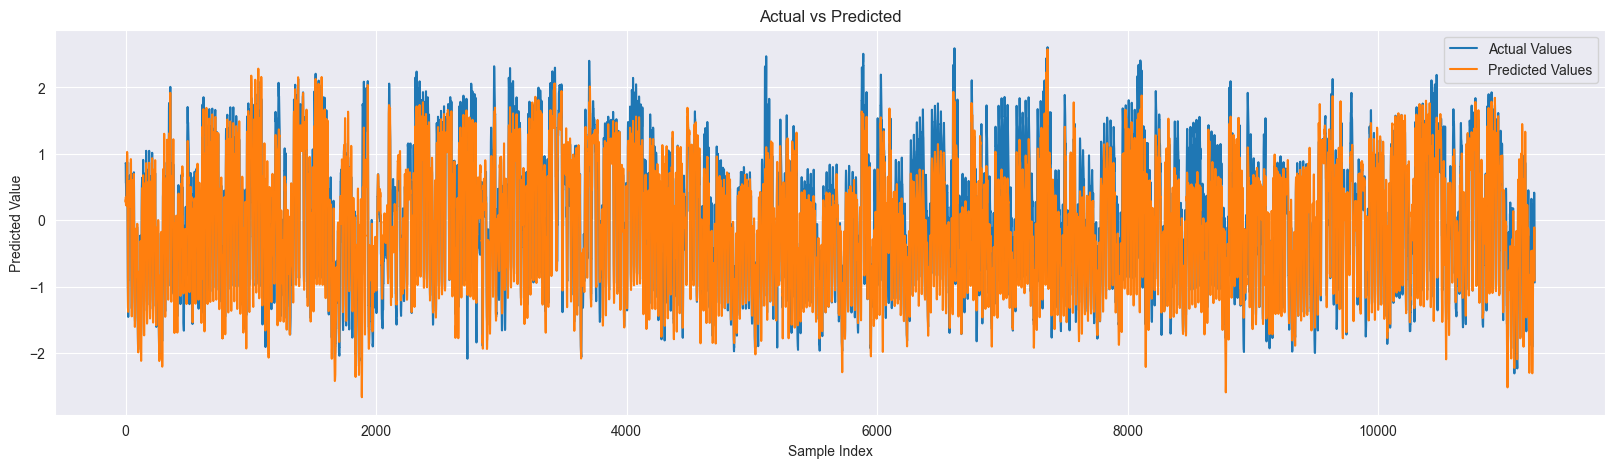

In [24]:
predictions = model_LSTM_5_old.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

352/352 [==============================] - 1s 1ms/step


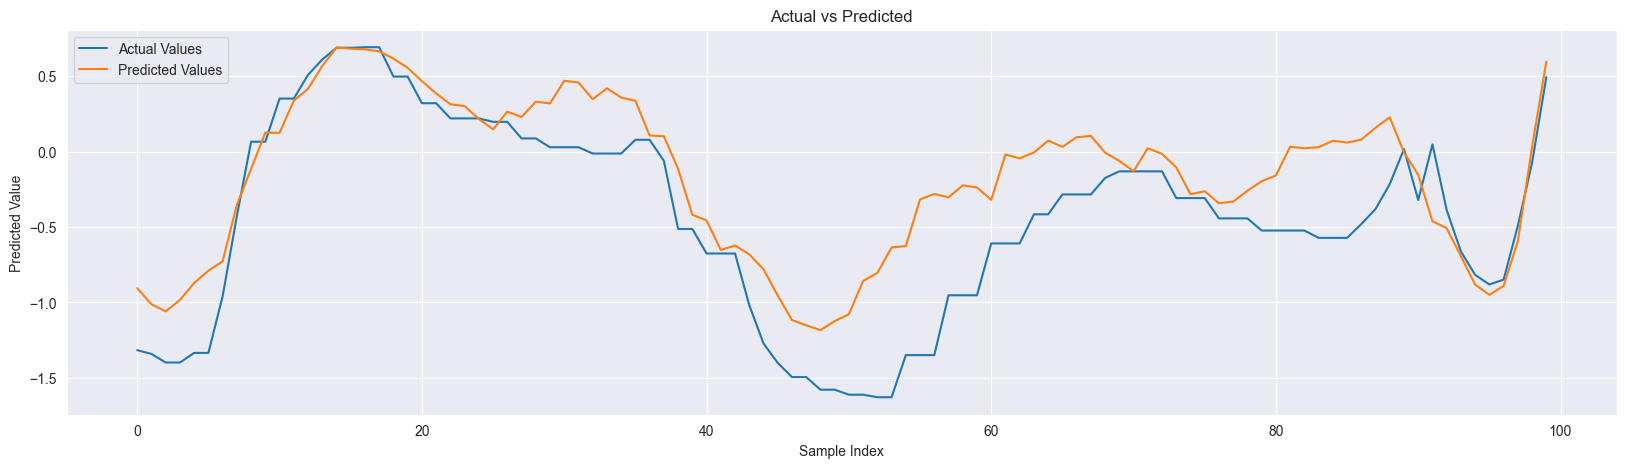

In [25]:
predictions = model_LSTM_5_old.predict(X_test)
plt.figure(figsize=(20, 5))
plt.plot(y_test[2000:2100], label='Actual Values')
plt.plot(predictions[2000:2100], label='Predicted Values')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

# Skumulowane wykresy dla najlepszych modeli

## Wykresy skumulowane dniami

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_daily_predictions(model, X_test, y_test, start_day, num_days, time_steps_per_day):
    num_complete_days = y_test.shape[0] // time_steps_per_day

    y_test_trimmed = y_test[:num_complete_days * time_steps_per_day]
    X_test_trimmed = X_test[:num_complete_days * time_steps_per_day]

    predictions = model.predict(X_test_trimmed)

    daily_actual = y_test_trimmed.reshape(-1, time_steps_per_day).sum(axis=1)
    daily_predictions = predictions.reshape(-1, time_steps_per_day).sum(axis=1)

    start_index = start_day
    end_index = start_day + num_days


    actual_to_plot = daily_actual[start_index:end_index]
    predictions_to_plot = daily_predictions[start_index:end_index]

    plt.figure(figsize=(20, 5))
    plt.plot(actual_to_plot, label='Actual Daily Values')
    plt.plot(predictions_to_plot, label='Predicted Daily Values')
    plt.title('Actual vs Predicted Daily Values')
    plt.xlabel('Day')
    plt.ylabel('Cumulative Value')
    plt.legend()
    plt.show()



## Najlepszy model z poprzednich zajęć

### Skumulowany wykres z 2 miesięcy

351/351 [==============================] - 1s 2ms/step


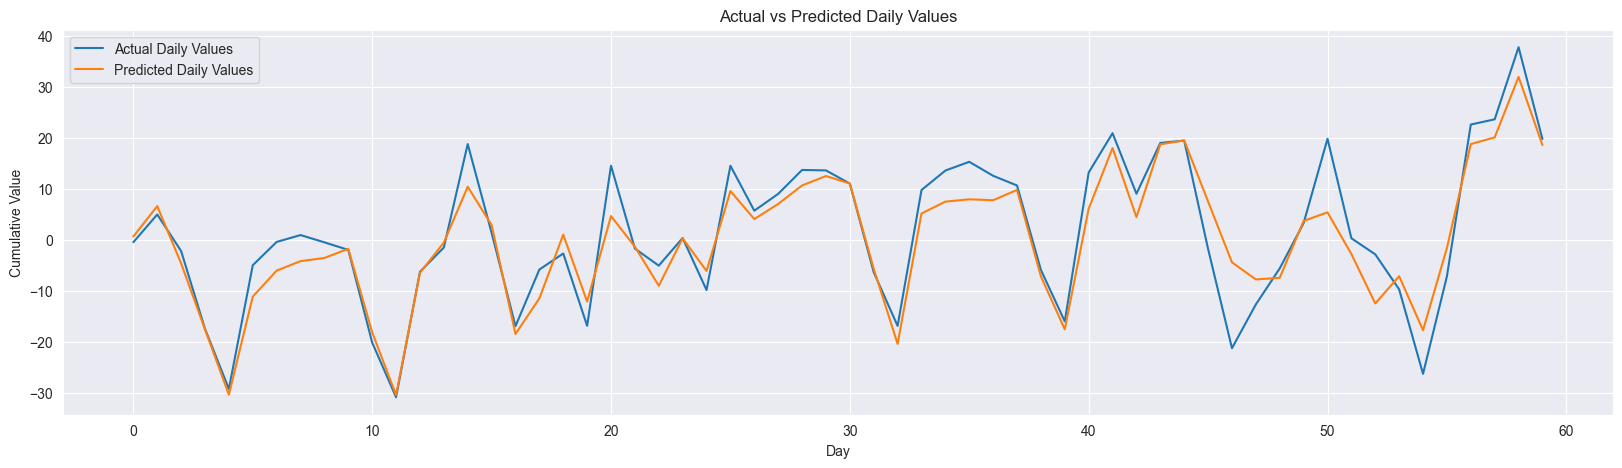

In [33]:
plot_daily_predictions(model_LSTM_5_old, X_test, y_test, start_day=0, num_days=60, time_steps_per_day=24)


## Dwa najlepsze modele z późniejszych eksperymentów

### Skumulowane wykresy z 2 miesięcy

### model21

351/351 [==============================] - 1s 1ms/step


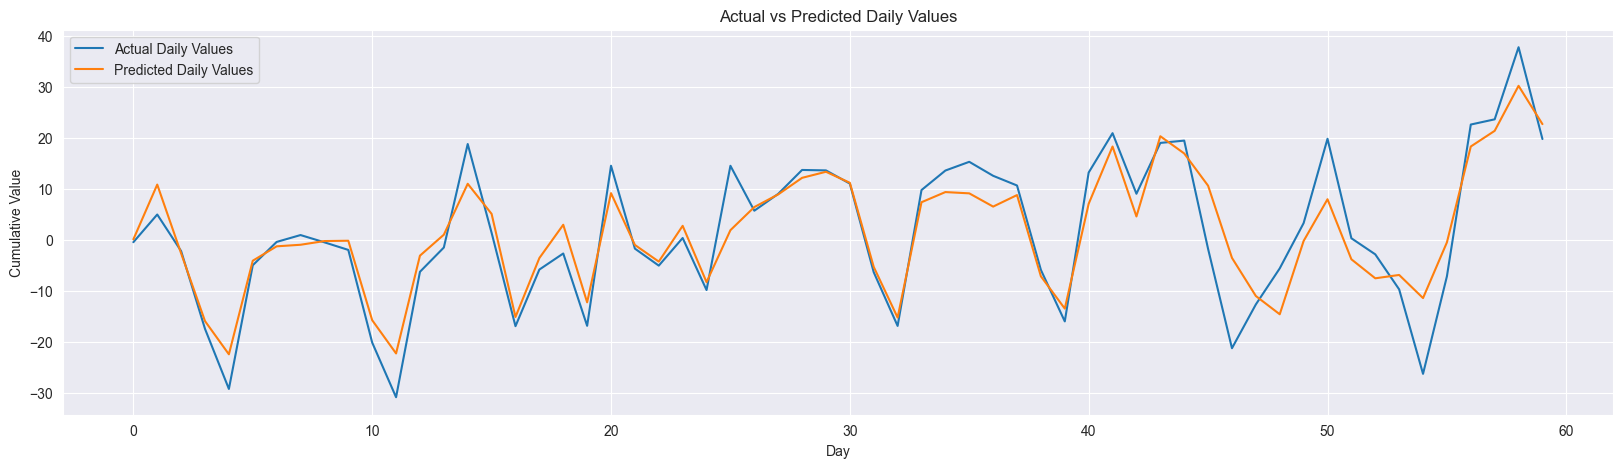

In [34]:
plot_daily_predictions(model21, X_test, y_test, start_day=0, num_days=60, time_steps_per_day=24)


### model15

351/351 [==============================] - 1s 1ms/step


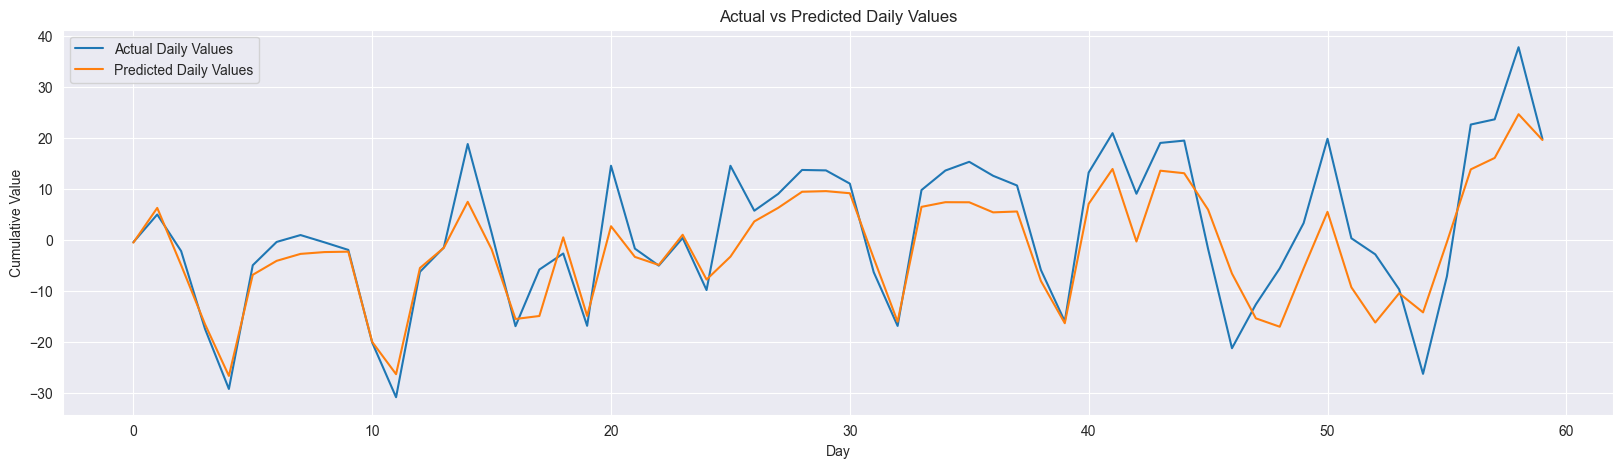

In [35]:
plot_daily_predictions(model15, X_test, y_test, start_day=0, num_days=60, time_steps_per_day=24)


Jak widać model15 i model21 wypadają podobnie na wykres. Nieco lepiej radzą sobie z odwzorowaniem danych testowych niż najlepszy model z poprzednich zajęć. Eksperymenty opłaciły się.

## Wykresy skumulowane miesiącami

In [42]:
def plot_monthly_cumulative_predictions(model, X_test, y_test, time_steps_per_day=24, months=6):
    predictions = model.predict(X_test)

    avg_month_length = int(30.44 * time_steps_per_day)

    num_complete_months = min(len(y_test), len(predictions)) // avg_month_length
    max_months = min(months, num_complete_months)

    monthly_actual = y_test[:max_months * avg_month_length].reshape(-1, avg_month_length).sum(axis=1).cumsum()
    monthly_predictions = predictions[:max_months * avg_month_length].reshape(-1, avg_month_length).sum(axis=1).cumsum()

    plt.figure(figsize=(20, 5))
    plt.plot(range(max_months), monthly_actual, label='Actual Monthly Cumulative Values')
    plt.plot(range(max_months), monthly_predictions, label='Predicted Monthly Cumulative Values')
    plt.title('Actual vs Predicted Monthly Cumulative Values')
    plt.xlabel('Month')
    plt.ylabel('Cumulative Value')
    plt.xticks(range(max_months), [f'Month {i+1}' for i in range(max_months)])
    plt.legend()
    plt.show()

### Najlepszy model z poprzednich zajęć

352/352 [==============================] - 0s 1ms/step


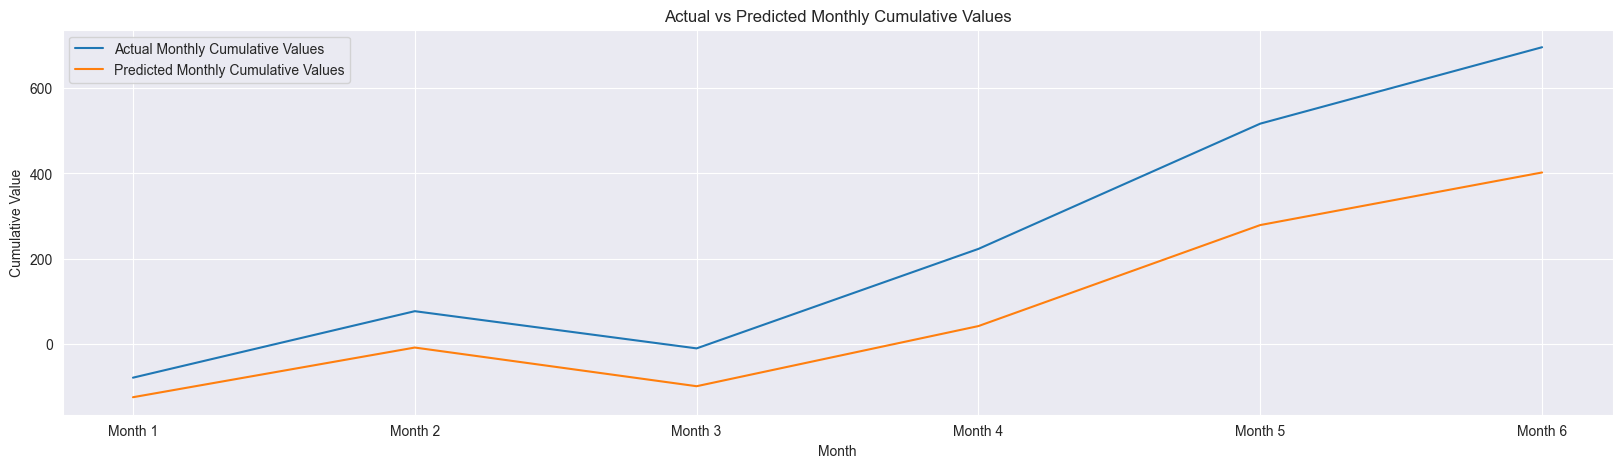

In [44]:
plot_monthly_cumulative_predictions(model_LSTM_5_old, X_test, y_test)


### model21

352/352 [==============================] - 0s 1ms/step


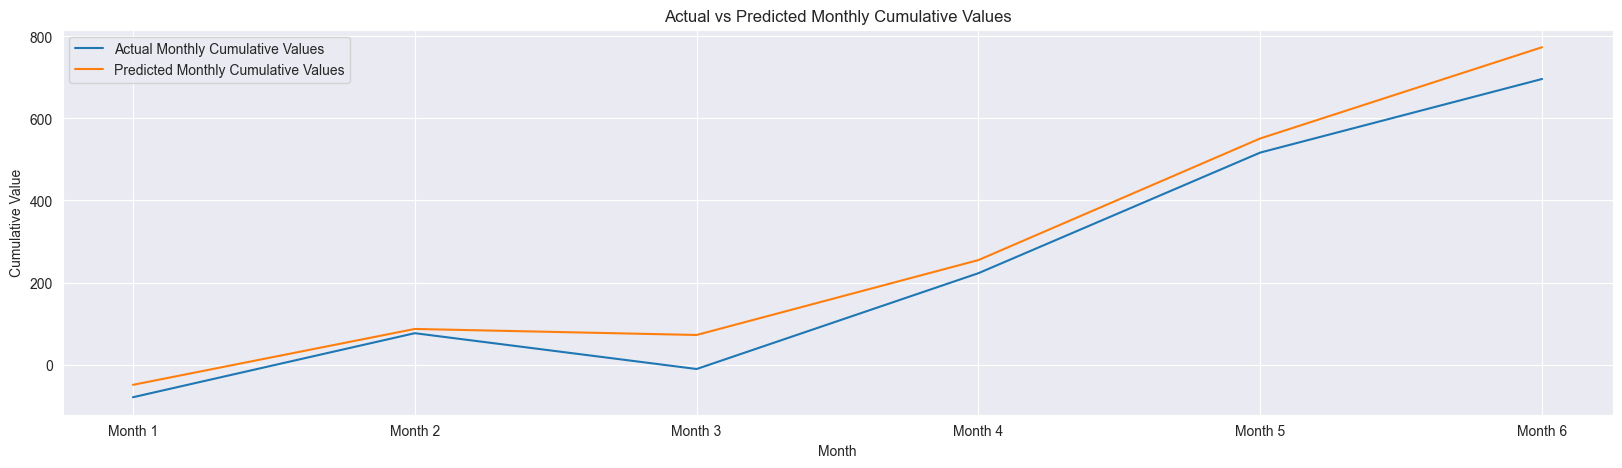

In [45]:
plot_monthly_cumulative_predictions(model21, X_test, y_test)


### model15

352/352 [==============================] - 1s 1ms/step


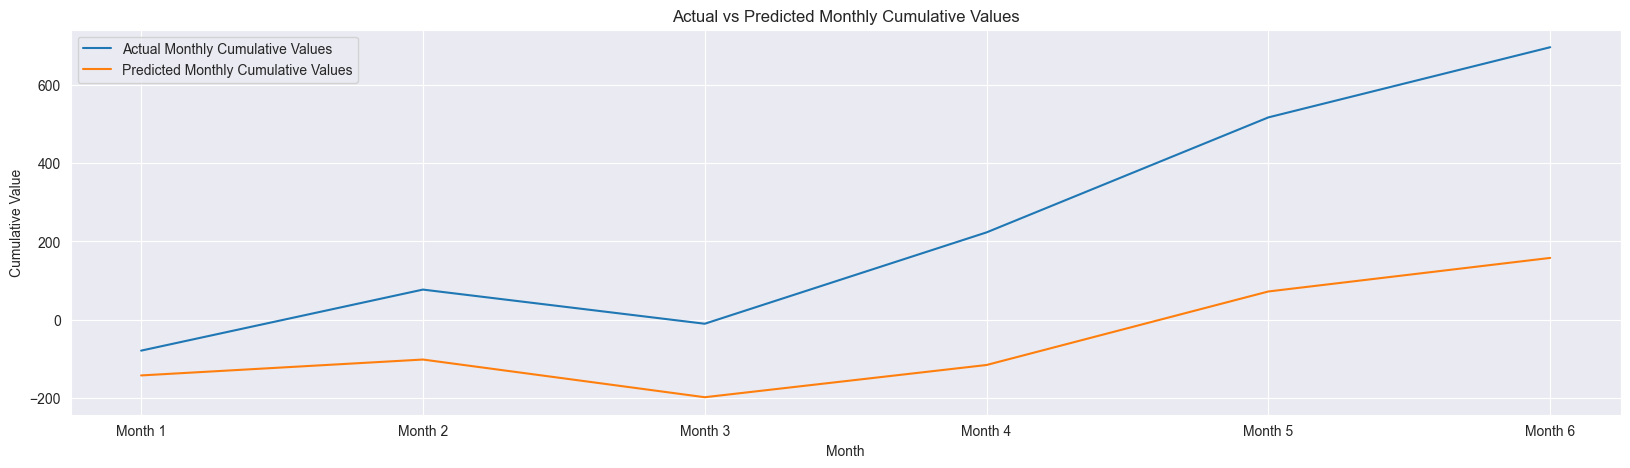

In [47]:
plot_monthly_cumulative_predictions(model15, X_test, y_test)


Jak można zauważyć zdecydowanie model21 wygrywa, zatem stanowi najlepsze odwzorowanie przewidywań do faktycznych danych z zbioru testowego.